EDA — Readmission for Diabetes Patients (Group Project) 

Using cleaned dataset: `jupyter-nb-space/explanations-encodedDataset/output.csv`. 

In [37]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility + display
np.random.seed(641)
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 140)

# --- paths ---
REPO_ROOT = Path(".").resolve()
DATA_DIR  = REPO_ROOT / "explanations-encodedDataset"
FIG_DIR   = REPO_ROOT / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Matplotlib defaults
plt.rcParams["figure.figsize"] = (7.5, 4.5)
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

print("Using data from:", DATA_DIR)

Using data from: C:\Users\ahswi\Documents\GitHub\readmission-for-diabetes-patients\jupyter-nb-space\explanations-encodedDataset


In [38]:
# The EDA-ready file
clean_file = DATA_DIR / "output.csv"
assert clean_file.exists(), f"{clean_file} not found. Pull latest main."

df = pd.read_csv(clean_file, low_memory=False)
print("Shape:", df.shape)
df.head(3)

Shape: (101766, 49)


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,1,2,0,6,25,1,1,0,1,41,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,149190,55629189,1,2,1,1,1,7,3,0,0,59,0,18,0,0,0,2,1,1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,1,2
2,64410,86047875,2,2,2,1,1,7,2,0,0,11,5,13,2,0,1,3,2,2,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [39]:
# Numerical columns.
columns_in_question_numerical = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
    'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses'
    ]

# Categorical columns.
columns_in_question_categorical = [
    'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id',
    'admission_source_id', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2',
    'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
    'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
    'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol',
    'troglitazone', 'tolazamide', """'examide', 'citoglipton',""" 'insulin',
    'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone',
    'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed'
    ]

# Subfolder names.
subfolder_names = [
    'plots_of_number_occurrences_per_readmitted_values', 'countplots',
    'numerical_plots_and_analysis', 'categorical_plots_and_analysis', 'correlation_heatmaps',
    'violinplots', 'pairplot', 'stripplot', 'proportion_plots', 'scatterplots'
]

# Encodings (kept here so plots show human-readable labels)
race_map   = {0:"?", 1:"Caucasian", 2:"AfricanAmerican", 3:"Asian", 4:"Hispanic", 5:"Other"}
gender_map = {0:"Unknown/Invalid", 1:"Male", 2:"Female"}
age_map    = {0:"[0-10)",1:"[10-20)",2:"[20-30)",3:"[30-40)",4:"[40-50)",5:"[50-60)",
              6:"[60-70)",7:"[70-80)",8:"[80-90)",9:"[90-100)"}

column_label_dictionaries = {
    "insulin": {0:"no", 1:"steady", 2:"up", 3:"down"},
    "A1Cresult": {0:"None", 1:"norm", 2:">7", 3:">8"},
    "max_glu_serum": {0:"None", 1:"norm", 2:">200", 3:">300"},
    "admission_type_id": {
        1:"Emergency", 2:"Urgent", 3:"Elective", 4:"Newborn", 5:"Not Available",
        6:"NULL", 7:"Trauma Center", 8:"Not Mapped"
    },
    "admission_source_id": {
        1:"Physician Referral", 2:"Clinic Referral", 3:"HMO Referral", 4:"Transfer from a hospital",
        5:"Transfer from a Skilled Nursing Facility (SNF)", 6:"Transfer from another health care facility",
        7:"Emergency Room", 8:"Court/Law Enforcement",
        9:"Not Available",          # There are two occurrencs of "Not Available".
        10:"Transfer from critial access hospital", 11:"Normal Delivery", 12:"Premature Delivery",
        13:"Sick Baby", 14:"Extramural Birth",
        15:"Not Available",         # There are two occurrencs of "Not Available".
        # 16 was skipped over.
        17:"NULL", 18:"Transfer From Another Home Health Agency",
        19:"Readmission to Same Home Health Agency", 20:"Not Mapped", 21:"Unknown/Invalid",
        22:"Transfer from hospital inpt/same fac reslt in a sep claim", 23:"Born inside this hospital",
        24:"Born outside this hospital", 25:"Transfer from Ambulatory Surgery Center",
        26:"Transfer from Hospice"
    },
    "discharge_disposition_id": {
        1:"Discharged to home", 2:"Discharged/transferred to another short term hospital",
        3:"Discharged/transferred to SNF", 4:"Discharged/transferred to ICF",
        5:"Discharged/transferred to another type of inpatient care institution",
        6:"Discharged/transferred to home with home health service",
        7:"Left AMA", 8:"Discharged/transferred to home under care of Home IV provider",
        9:"Admitted as an inpatient to this hospital",
        10:"Neonate discharged to another hospital for neonatal aftercare",
        11:"Expired", 12:"Still patient or expected to return for outpatient services",
        13:"Hospice / home", 14:"Hospice / medical facility",
        15:"Discharged/transferred within this institution to Medicare approved swing bed",
        16:"Discharged/transferred/referred another institution for outpatient services",
        17:"Discharged/transferred/referred to this institution for outpatient services",
        18:"NULL",
        19:"Expired at home. Medicaid only, hospice.",
        20:"Expired in a medical facility. Medicaid only, hospice.",
        21:"Expired, place unknown. Medicaid only, hospice.",
        22:"Discharged/transferred to another rehab fac including rehab units of a hospital.",
        23:"Discharged/transferred to a long term care hospital.",
        24:"Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.",
        25:"Not Mapped", 26:"Unknown/Invalid",
        27:"Discharged/transferred to a federal health care facility.",
        28:"Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital",
        29:"Discharged/transferred to a Critical Access Hospital (CAH).",
        30:"Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere"
    }
}
# Target: 0=no, 1=<30, 2=>30
readmit_map = {0:"no", 1:"<30", 2:">30"}

# Labs
a1c_map = {0:"None", 1:"norm", 2:">7", 3:">8"}
glu_map = {0:"None", 1:"norm", 2:">200", 3:">300"}

# Insulin (0=no, 1=steady, 2=up, 3=down)
insulin_map = {0:"no", 1:"steady", 2:"up", 3:"down"}

# Convenient helper to map safely if the column exists
def map_labels(series, mapping):
    s = series.copy()
    try:
        s = s.astype("Int64")
    except Exception:
        pass
    return s.map(mapping).fillna(series)

# Convenience: name of target column
TARGET = "readmitted"

# Convenient helper to output provided text to a file.
def output_text_information_to_txt_file(file_name, file_content):
    with open(file_name + ".txt", 'w') as file:
        file.write(file_content)

# Convenient helper to create subfolders.
def create_folder(folder_location, folder_name):
    nested_directory = folder_location + "/" + folder_name

    folder_exists = False

    status_string = ""

    try:
        os.makedirs(nested_directory)
        status_string = f"Folder '{folder_name}' successfully created in '{folder_location}'."
        folder_exists = True
    except FileExistsError:
        status_string = f"Folder '{folder_name}' already exists in '{folder_location}'."
        folder_exists = True
    except PermissionError:
        status_string = f"Permission Denied: Folder '{folder_name}' could not be created in '{folder_location}'."
    except Exception as e:
        status_string = f"An error occurred: {e}"
    
    return folder_exists, status_string, nested_directory

### UNIVARIATE
1. Overall bar for 30-day readmissions (target distribution)

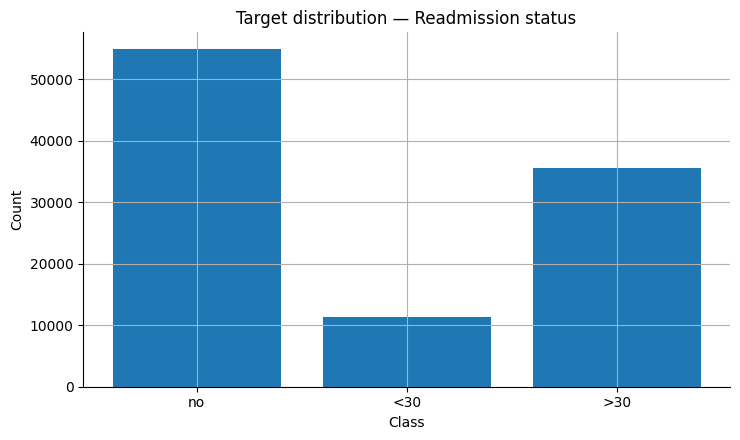

In [40]:
folder_exists, status_string, nested_directory = create_folder(str(FIG_DIR), subfolder_names[0])

if (folder_exists):
    counts = df[TARGET].value_counts().sort_index()
    labels = [readmit_map.get(int(k), str(k)) for k in counts.index]

    plt.figure()
    plt.bar(labels, counts.values)
    plt.title("Target distribution — Readmission status")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(FIG_DIR / "target_distribution_readmitted.png", dpi=150)
    plt.show()

    # also percentages (for write-up)
    (counts / counts.sum() * 100).round(2)
else:
    output_text_information_to_txt_file(nested_directory + "/Error", status_string)

The outcome is imbalanced (one class is much smaller than the others): no is 53.91%, <30 is 11.16%, and >30 is 34.93%. Because <30 is the minority class (the small group we care about), plain accuracy can be misleading. 

We will use stratified splits (we keep the same class proportions in train and test) and evaluate with recall (of all true <30 cases, how many we correctly find) and precision (of the cases we predict as <30, how many are actually <30>). We will also track PR-AUC (the area under the precision–recall curve) which is a better summary than accuracy when classes are imbalanced. Finally, we will tune the decision threshold (the cutoff where a probability becomes a positive prediction) to hit a target recall for <30.

2. Race/Ethnicity — bar plot of 30-day readmission rate by race

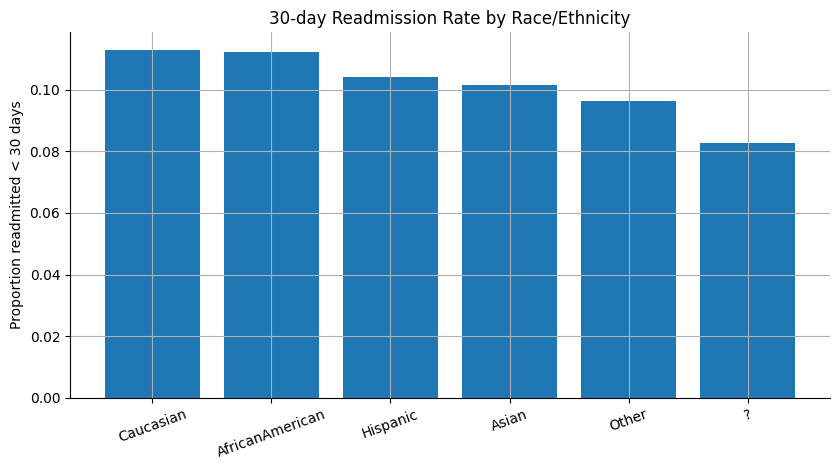

race
1    0.112906
2    0.112181
4    0.104075
3    0.101404
5    0.096282
0    0.082710
Name: readmitted, dtype: float64


In [41]:
folder_exists, status_string, nested_directory = create_folder(str(FIG_DIR), subfolder_names[8])

if (folder_exists):
    col = "race"
    tmp = df[[col, TARGET]].dropna()
    rate = (tmp[TARGET] == 1).groupby(tmp[col]).mean().sort_values(ascending=False)

    x_labels = [race_map.get(int(k), str(k)) for k in rate.index]

    plt.figure(figsize=(8.5, 4.8))
    plt.bar(x_labels, rate.values)
    plt.ylabel("Proportion readmitted < 30 days")
    plt.title("30-day Readmission Rate by Race/Ethnicity")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.savefig(nested_directory + "/rate_readmit_lt30_by_race.png", dpi=150)
    plt.show()

    print(rate)
else:
    output_text_information_to_txt_file(nested_directory + "/Error", status_string)

The <30 rates across racial groups are tightly clustered (Caucasian 11.29%, African American 11.22%, Hispanic 10.41%, Asian 10.14%, Other 9.63%, Unknown 8.27%) so differences are only a few percentage points (a percentage-point is the simple arithmetic difference between two percentages, e.g., 12% vs 10% = 2 points). This suggests a weak association (little relationship) between race and 30-day readmission in this dataset. 

We will still report fairness slices (metrics computed within each group) to confirm the model behaves similarly across groups, but we do not expect race by itself to add meaningful predictive lift (performance gain).

3. Age — distribution (counts)

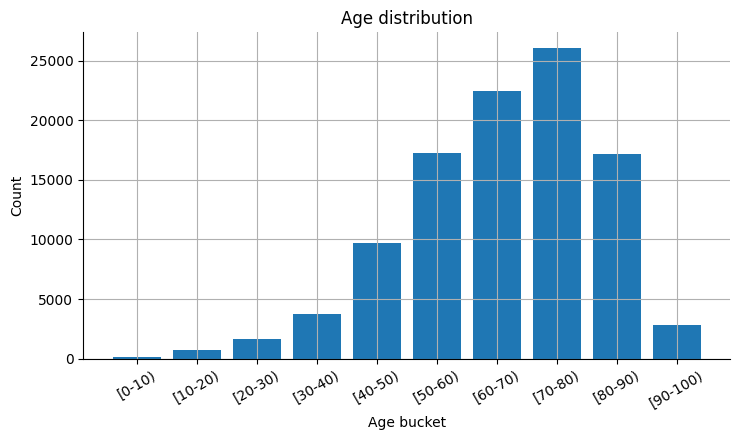

age
0      161
1      691
2     1657
3     3775
4     9685
5    17256
6    22483
7    26068
8    17197
9     2793
Name: count, dtype: int64


In [42]:
folder_exists, status_string, nested_directory = create_folder(str(FIG_DIR), subfolder_names[1])

if (folder_exists):
    col = "age"
    counts = df[col].value_counts().sort_index()
    labels = [age_map.get(int(k), str(k)) for k in counts.index]

    plt.figure()
    plt.bar(labels, counts.values)
    plt.title("Age distribution")
    plt.xlabel("Age bucket")
    plt.ylabel("Count")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.savefig(nested_directory + "/age_distribution.png", dpi=150)
    plt.show()

    print(counts)
else:
    output_text_information_to_txt_file(nested_directory + "/Error", status_string)

Encounter counts skew older as the largest bucket is 70–80 (26,068), followed by 60–70 (22,483) and 50–60 (17,256), while younger buckets are smaller. Smaller groups give noisier estimates (more variability just due to few examples). 

We will stratify by age in our data splits so train and test have similar age mixes, and we will be cautious interpreting patterns in the youngest buckets.

4. Gender — distribution (counts) and <30 rate

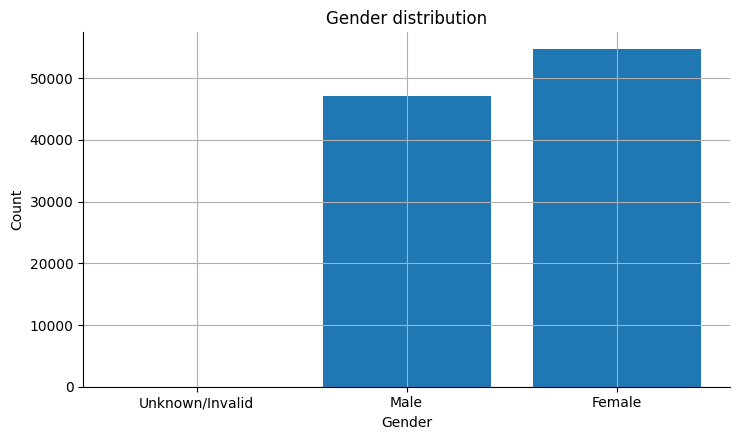

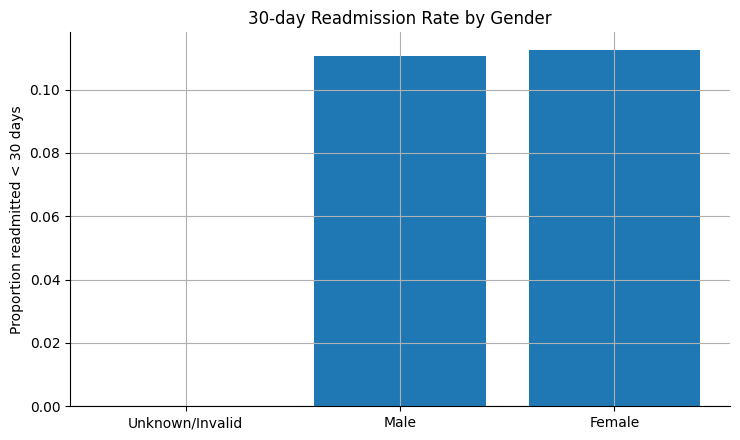

gender
0    0.000000
1    0.110615
2    0.112452
Name: readmitted, dtype: float64


In [43]:
col = "gender"
# counts
g_counts = df[col].value_counts().sort_index()
g_labels = [gender_map.get(int(k), str(k)) for k in g_counts.index]


folder_exists, status_string, nested_directory = create_folder(str(FIG_DIR), subfolder_names[1])

if (folder_exists):

    plt.figure()
    plt.bar(g_labels, g_counts.values)
    plt.title("Gender distribution")
    plt.xlabel("Gender")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(nested_directory + "/gender_distribution.png", dpi=150)
    plt.show()
else:
    output_text_information_to_txt_file(nested_directory + "/Error", status_string)


folder_exists, status_string, nested_directory = create_folder(str(FIG_DIR), subfolder_names[8])

if (folder_exists):
    # <30 rate
    tmp = df[[col, TARGET]].dropna()
    rate = (tmp[TARGET] == 1).groupby(tmp[col]).mean().reindex(g_counts.index)

    plt.figure()
    plt.bar(g_labels, rate.values)
    plt.title("30-day Readmission Rate by Gender")
    plt.ylabel("Proportion readmitted < 30 days")
    plt.tight_layout()
    plt.savefig(nested_directory + "/rate_readmit_lt30_by_gender.png", dpi=150)
    plt.show()

    print(rate)
else:
    output_text_information_to_txt_file(nested_directory + "/Error", status_string)

Male and Female have nearly identical <30 rates—11.06% and 11.25%, respectively while the Unknown/Invalid group is tiny. That indicates minimal predictive signal (little ability to separate classes) from gender for this outcome. 

We will keep gender for completeness and for fairness slicing, but we do not expect it to materially improve performance.

5. General - Distribution (counts) at < 30 readmission rate.

In [44]:
def get_chart_width(df_imported, current_element, default_max):
    current_column_values = df_imported[current_element]

    chart_width = current_column_values.nunique()

    if (chart_width > default_max):
        chart_width = default_max
    
    return chart_width, current_column_values


def do_basic_analysis_and_charts(columns_of_interest, numerical_or_categorical, df_imported, x_label_rotation, folder_location, folder_name, column_label_dictionaries):
    folder_exists, status_string, nested_directory = create_folder(folder_location, folder_name)

    output_string = ""

    columns_of_interest.append(TARGET)
    temp_reduced_df = df_imported[columns_of_interest]
    temp_reduced_df = temp_reduced_df[temp_reduced_df[TARGET] == 1]
    temp_reduced_df = temp_reduced_df.drop(TARGET, axis=1)

    if (folder_exists):
        try:
            current_image_count = 0
            
            for element in columns_of_interest:
                nested_directory_and_name = nested_directory + "/" + element + "_" + str(current_image_count) + ".png"

                chart_width, current_column_values = get_chart_width(temp_reduced_df, element, 100)

                possible_column_label_dictionary = column_label_dictionaries.get(element)
                if (possible_column_label_dictionary is not None):
                    category_counts = temp_reduced_df[element].value_counts().sort_index()
                    category_labels = [possible_column_label_dictionary.get(int(k), str(k)) for k in category_counts.index]

                if (numerical_or_categorical == 'numerical'):
                    fig, (ax_box, ax_bar) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(chart_width, 10))
                    plt.title(f"Distribution of unique values in '{element}' where 'readmitted' < 30.")
                    sns.boxplot(x=current_column_values, ax=ax_box)
                    if (possible_column_label_dictionary is not None):
                        ax = plt.bar(category_labels, category_counts.values, ax=ax_bar)
                    else:
                        ax = sns.countplot(x=element, data=temp_reduced_df, orient='v', ax=ax_bar)
                        for container in ax.containers:
                            ax.bar_label(container)
                    plt.xlabel('Values')
                    plt.xticks(rotation=x_label_rotation, ha='right')
                    plt.ylabel('Counts')
                    plt.tight_layout()
                    plt.savefig(nested_directory_and_name, dpi=150)
                    plt.show()
                    plt.close()
                
                if (numerical_or_categorical == 'categorical'):
                    fig, ax = plt.subplots(figsize=(chart_width, 10))
                    plt.title(f"Distribution of unique values in '{element}' where 'readmitted' < 30.")
                    if (possible_column_label_dictionary is not None):
                        plt.bar(category_labels, category_counts.values)
                    else:
                        ax = sns.countplot(x=element, data=temp_reduced_df, orient='v')
                        for container in ax.containers:
                            ax.bar_label(container)
                    plt.xlabel('Values')
                    plt.xticks(rotation=x_label_rotation, ha='right')
                    plt.ylabel('Counts')
                    plt.savefig(nested_directory_and_name, dpi=150)
                    plt.show()
                    plt.close()

                if (numerical_or_categorical == 'numerical'):
                    current_mean = current_column_values.mean()
                    current_median = current_column_values.median()
                    current_mode = current_column_values.mode()
                    current_midrange = (current_column_values.min() + current_column_values.max())/2
                    output_string += f"Measures of center for the '{element}' column:\nMean: {current_mean}\nMedian: {current_median}\nMode: {current_mode}\nMidrange: {current_midrange}\n"

                    current_standard_deviation = current_column_values.std()
                    current_variance = current_column_values.var()
                    current_quantile = current_column_values.quantile()
                    output_string += f"Measures of spread for the '{element}' column:\nStandard Deviation: {current_standard_deviation}\nVariance: {current_variance}\nQuantile: {current_quantile}\n\n"
                
                if (numerical_or_categorical == 'categorical'):
                    output_string += f"Number of occurrences of each category in '{element}':\n{str(current_column_values.value_counts().sort_index())}\n"

                current_image_count += 1

            output_text_information_to_txt_file("result_of_data_check_on_columns", status_string + "\n\n\n" + output_string)
        except Exception as e:
            output_text_information_to_txt_file(nested_directory + "/Error", str(e))
    else:
        output_text_information_to_txt_file(nested_directory + "/Error", status_string)

Distribution (counts) at < 30 readmission rate for a number of relevant numerical columns.

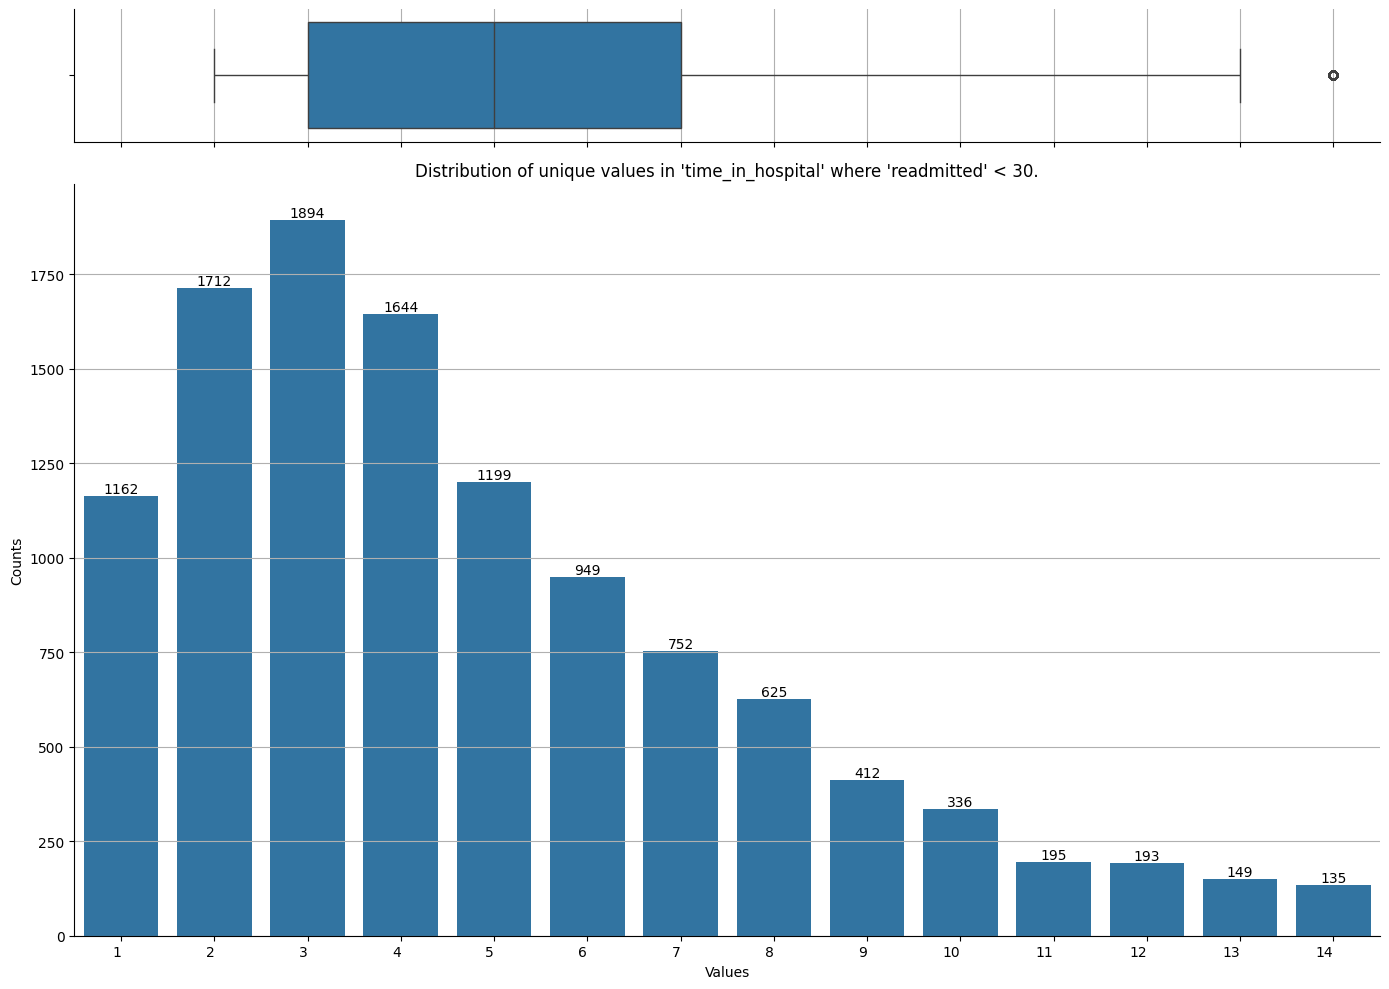

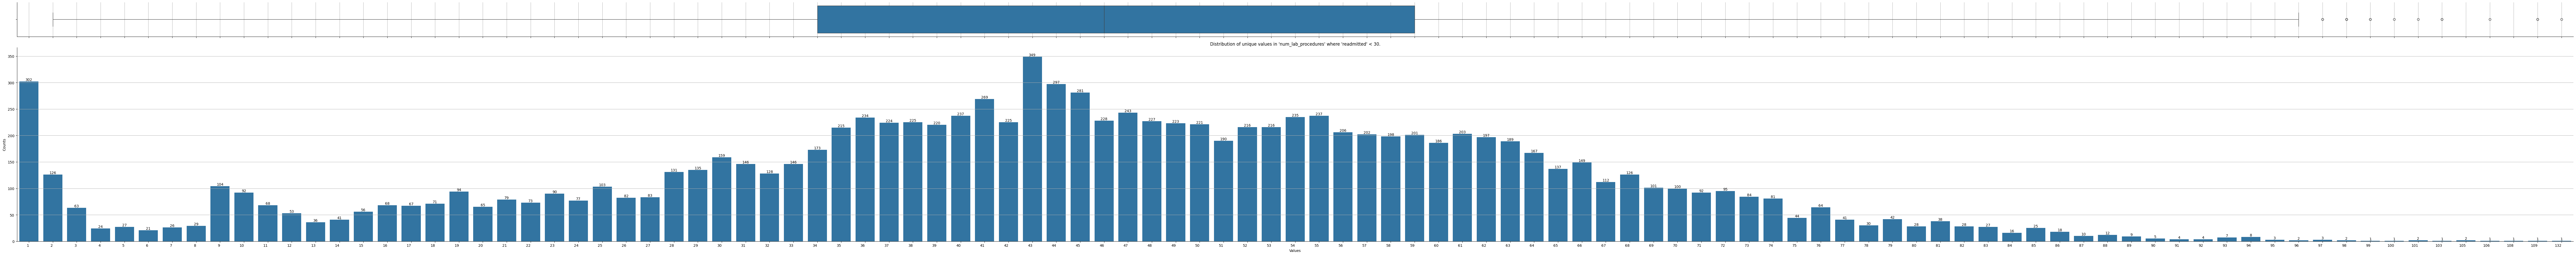

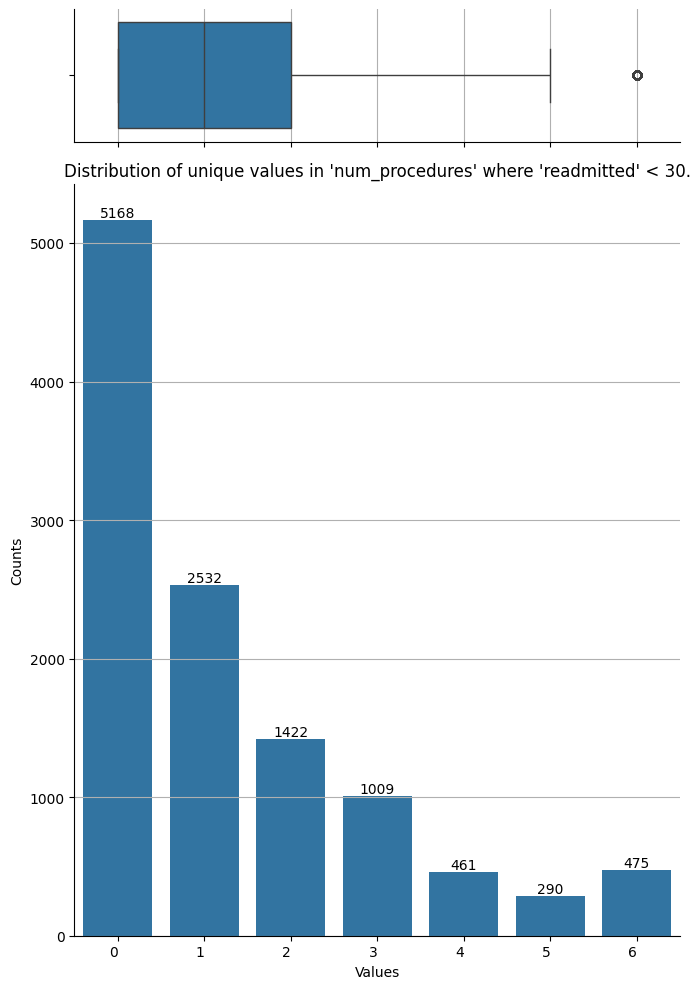

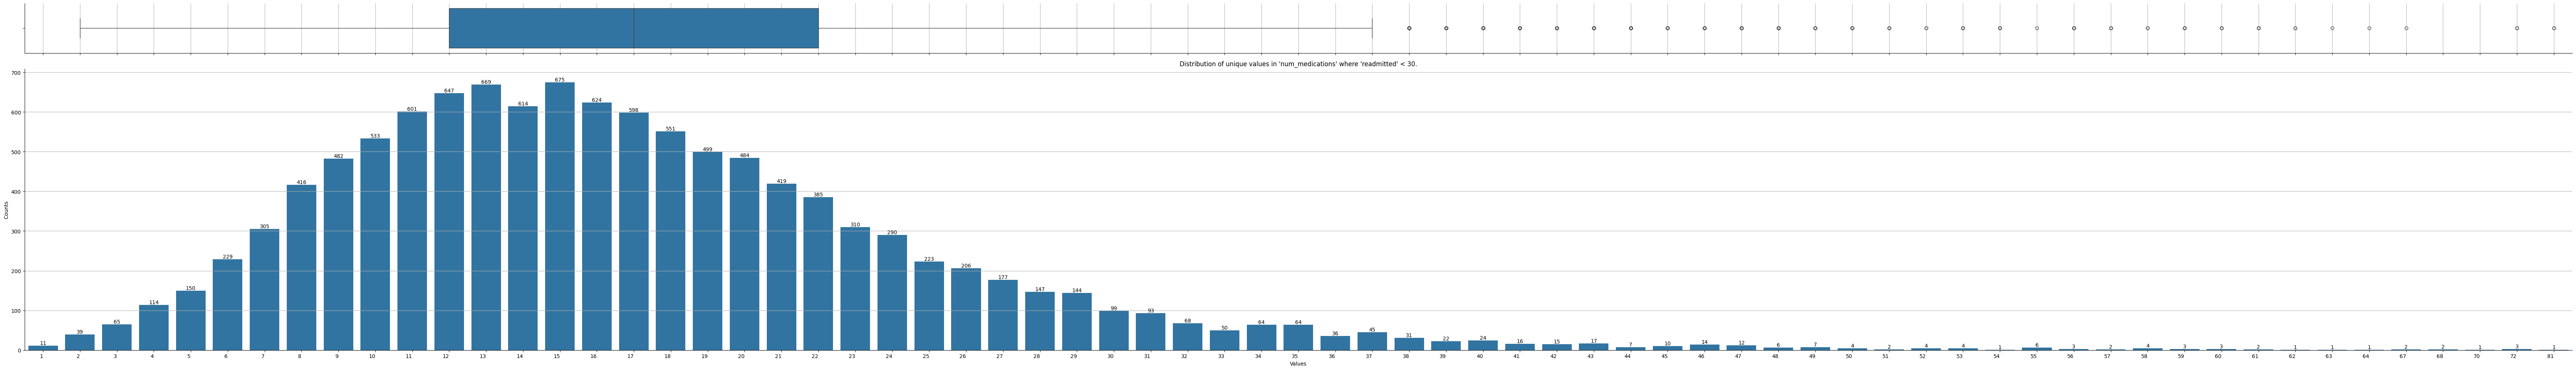

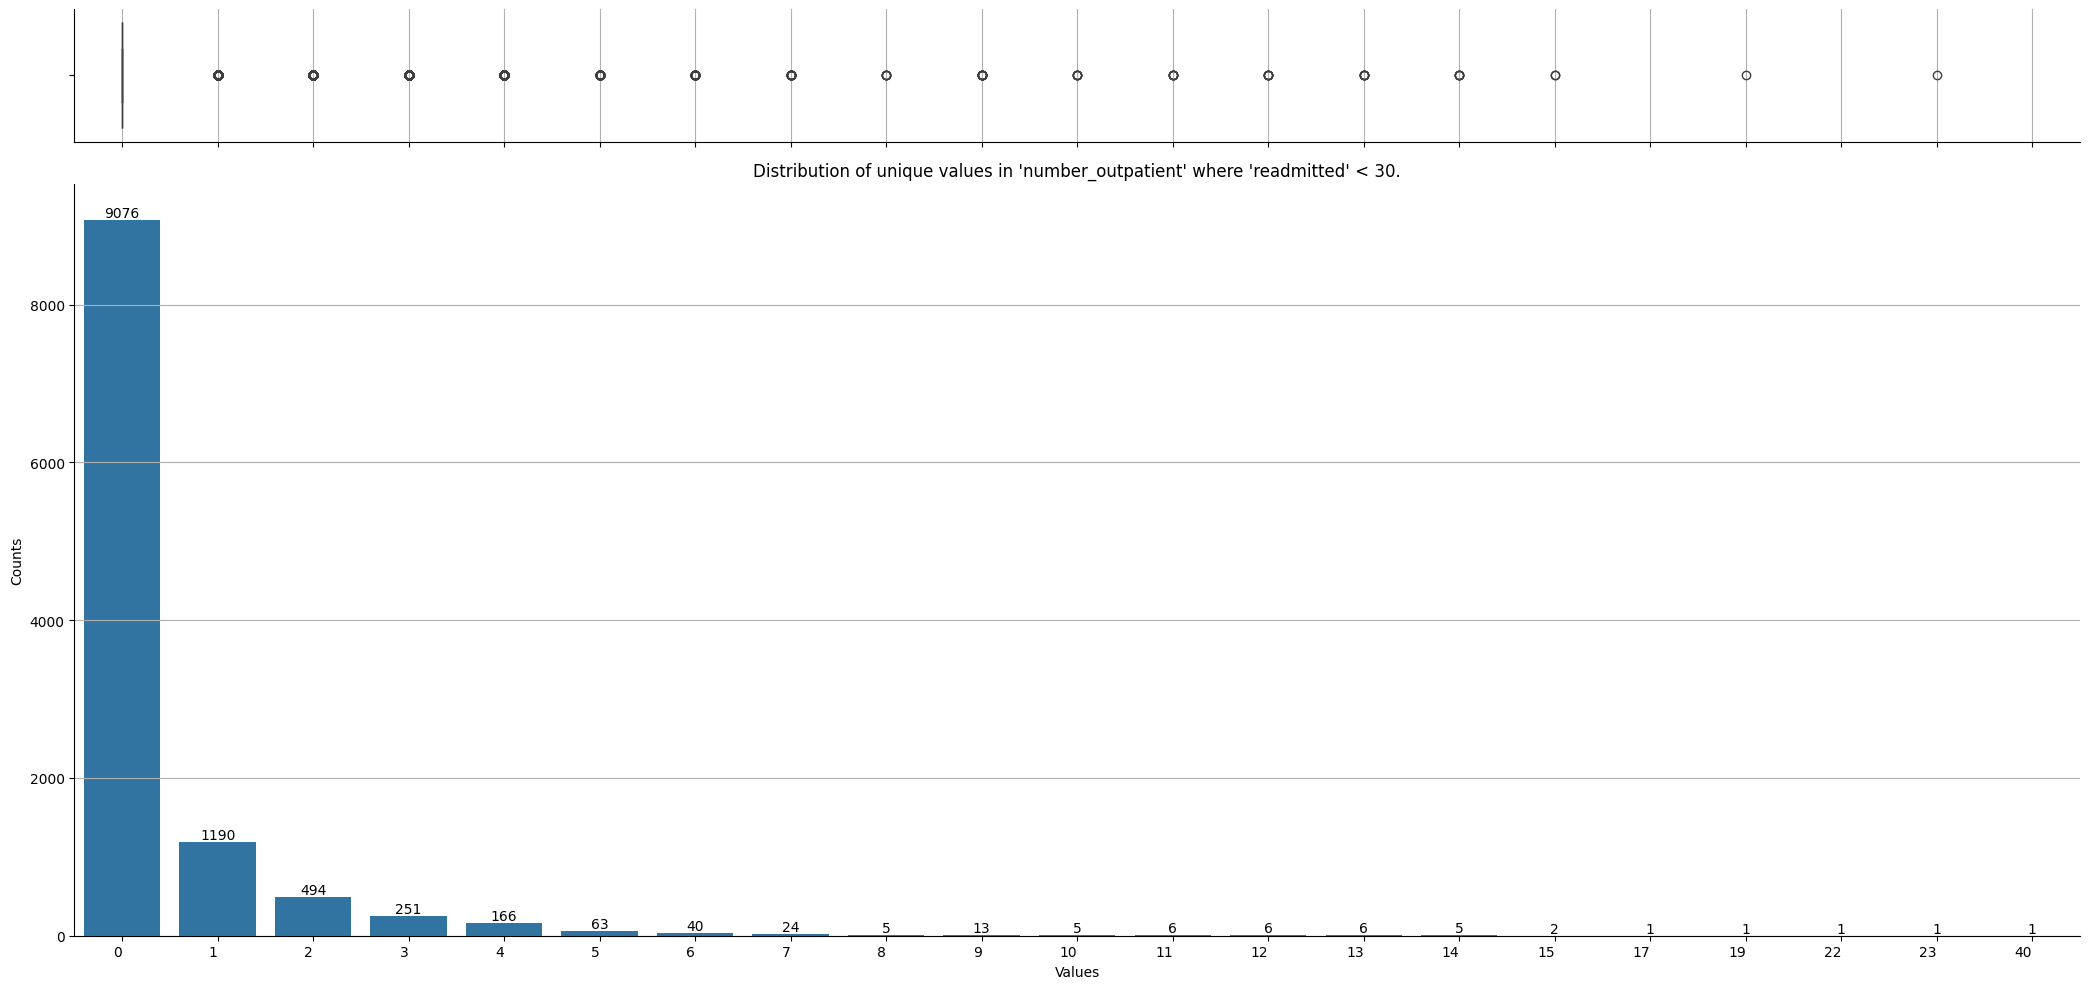

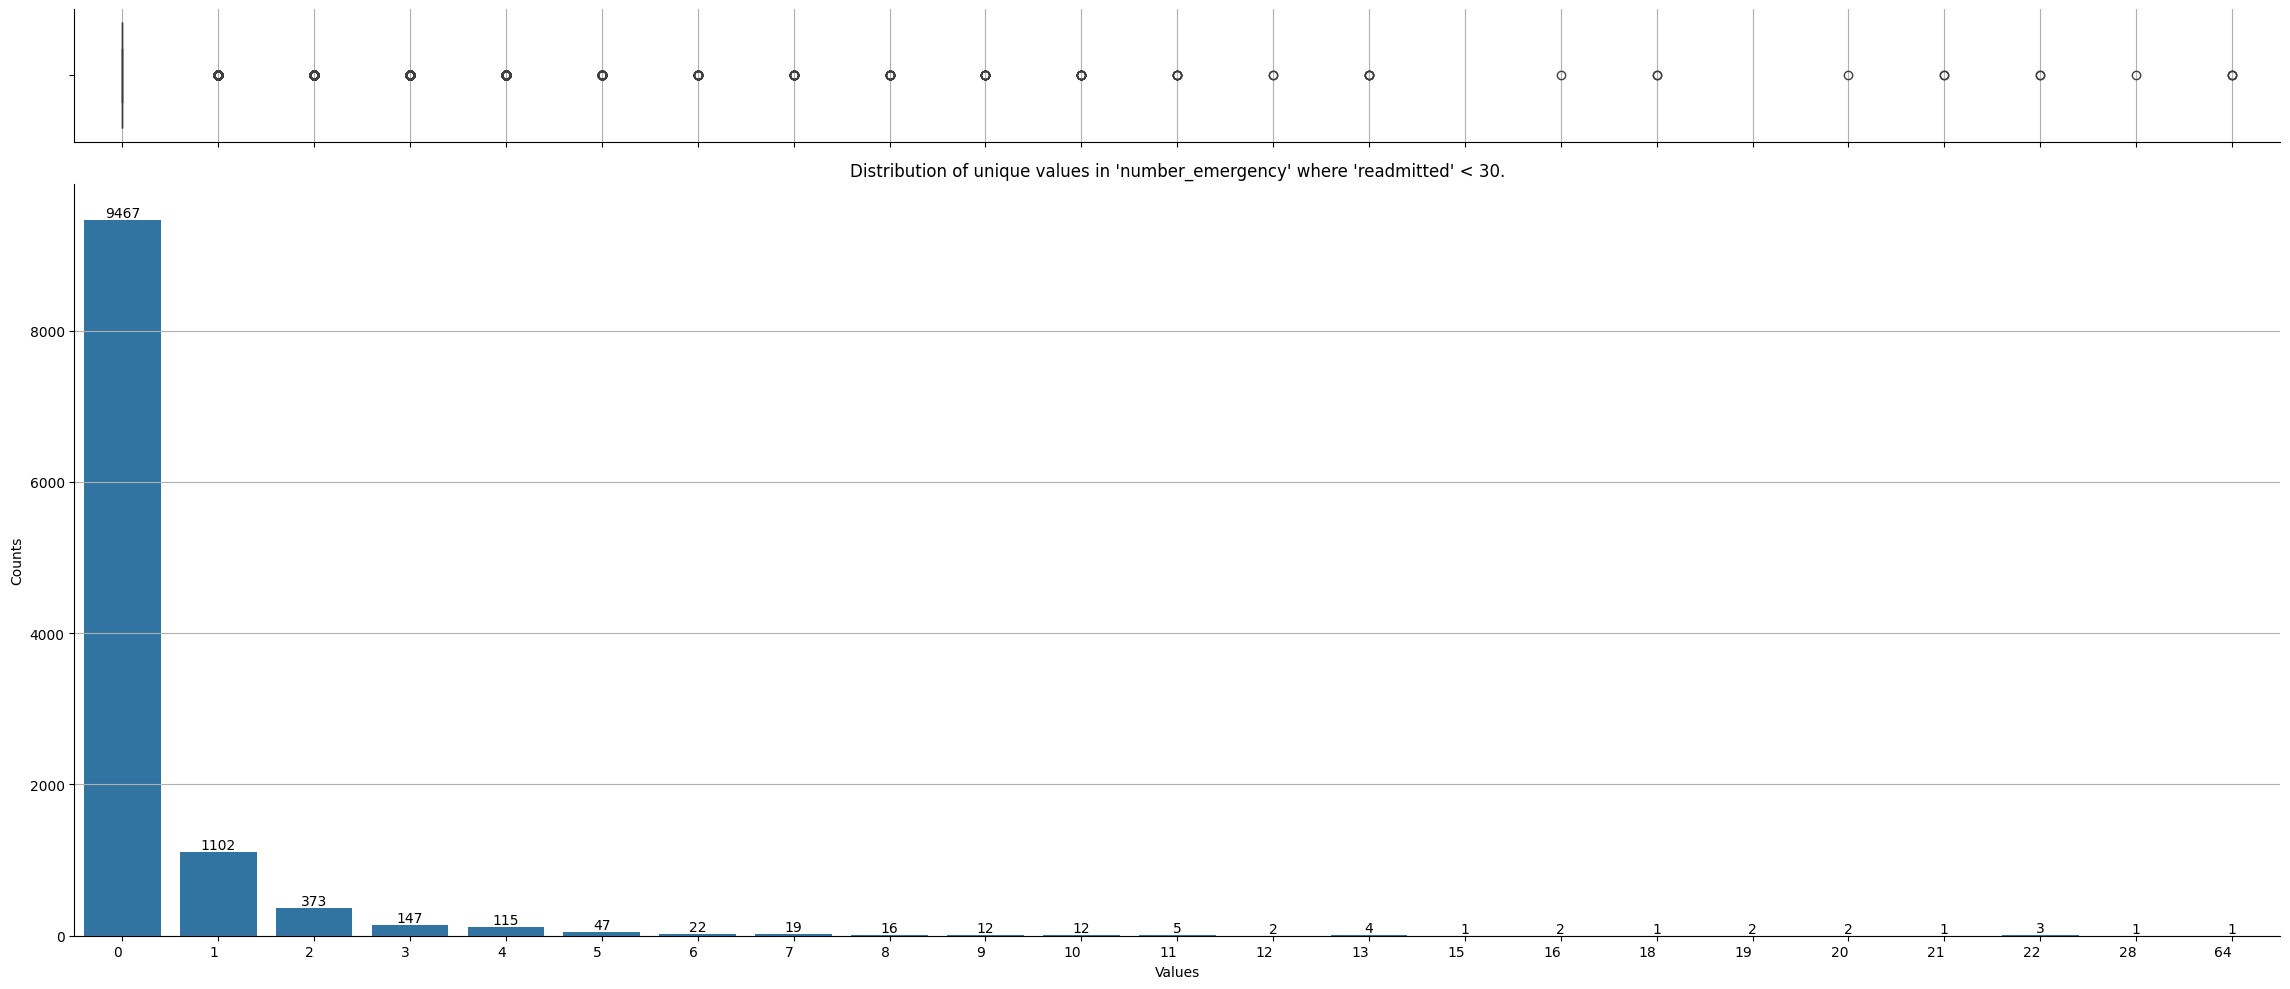

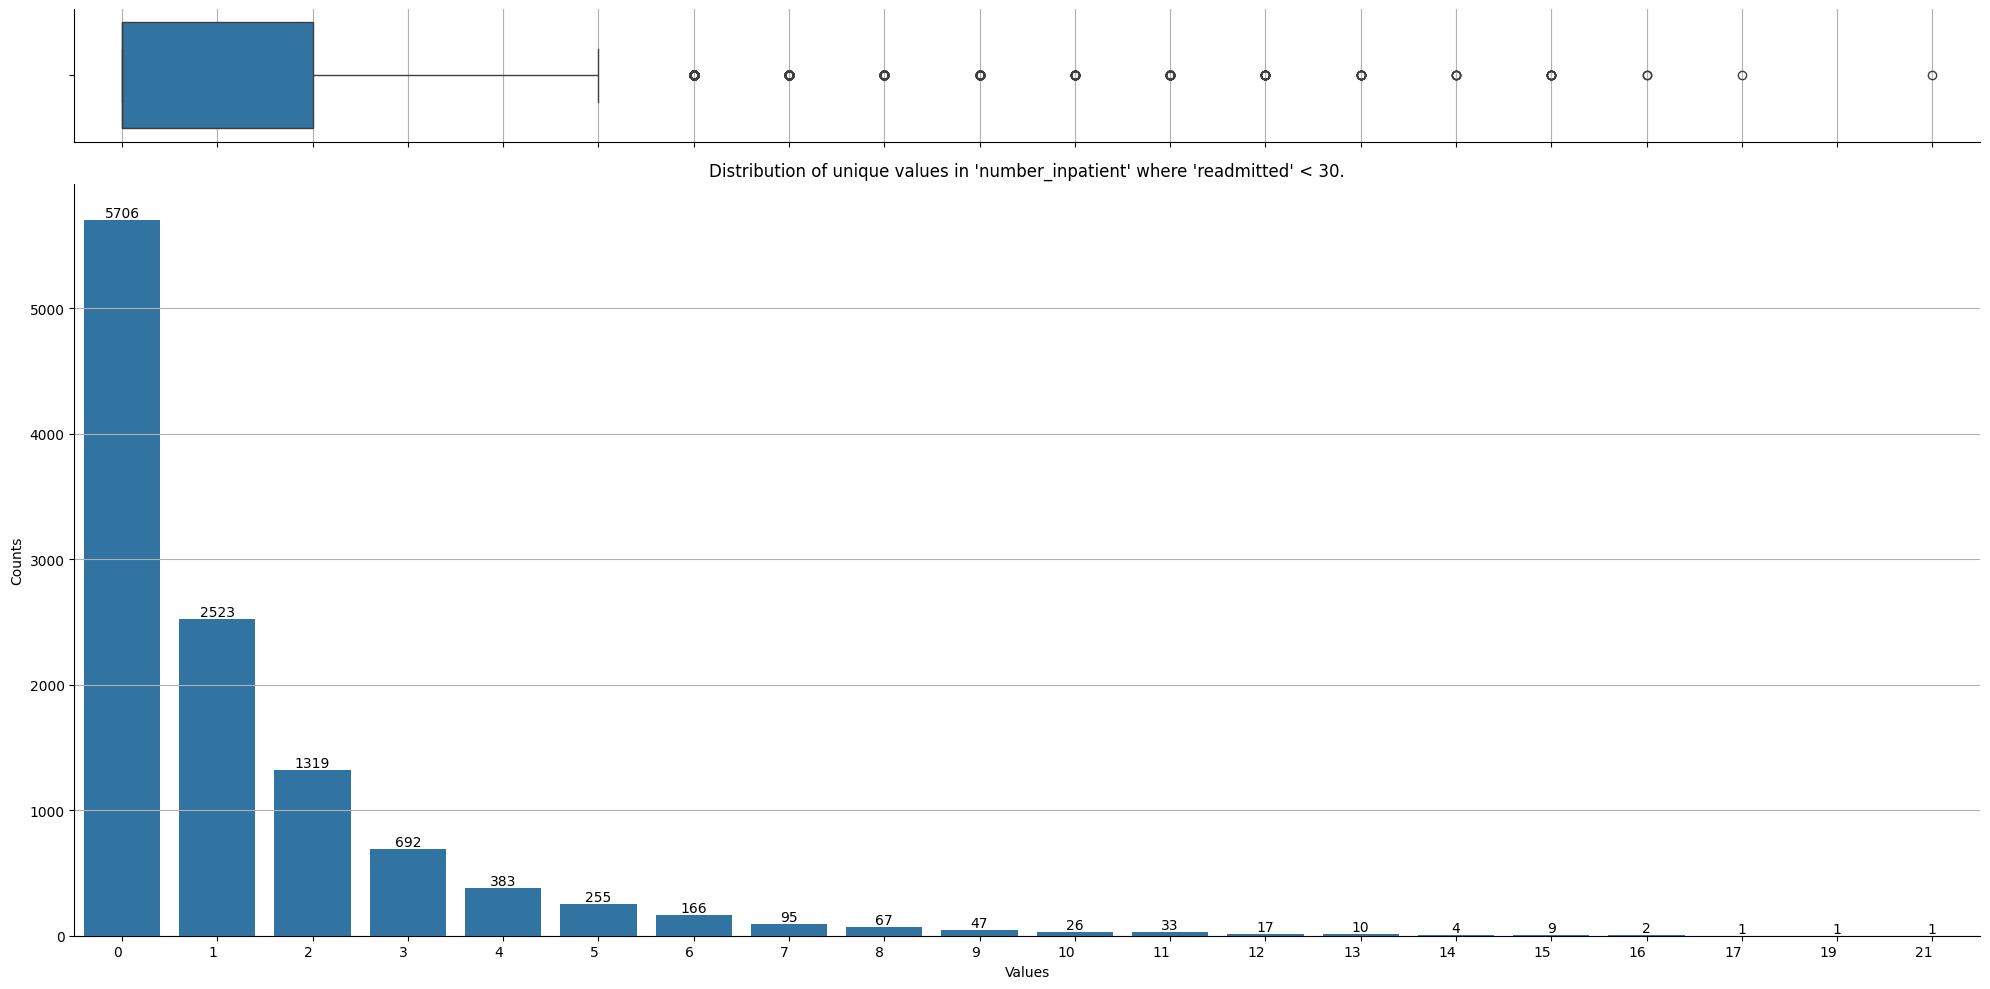

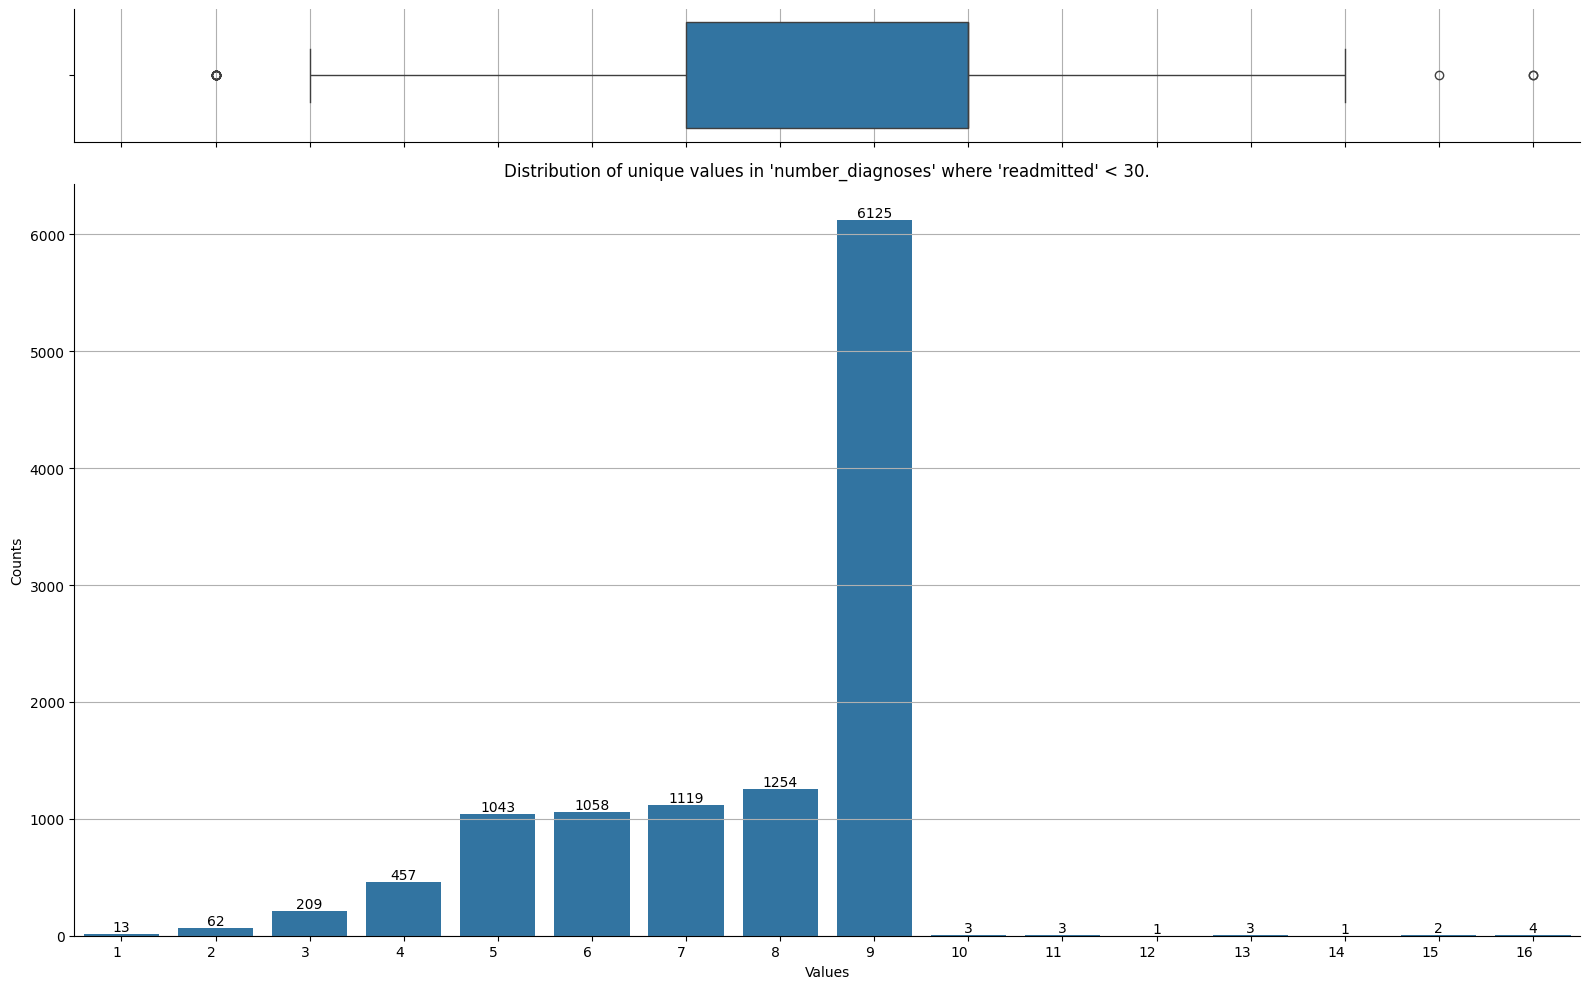

In [45]:
columns_of_interest_numerical = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
    'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses'
    ]

do_basic_analysis_and_charts(columns_of_interest_numerical, 'numerical', df, 0, str(FIG_DIR), subfolder_names[1], column_label_dictionaries)

The following graphs for some numerical columns were done on a version of dataset that only contains patients who were readmitted within 30 days of their prior visit.

"time_in_hospital"
* Right skewed.
* Many more patients are in the hospital for shorter periods of time (less than 1 week), with the majority staying in the hospital from 3 to 7 days, inclusive.
* This column is important to keep, as it will likely have decent predictive power.

"num_lab_procedures"
* Right skewed.
* Is a bimodal distribution. Much of the patients have between 34 and 59 lab procedures, inclusive. After 43 lab procedures (the number with the second highest amount of patients), the number of patients who have more procedures gradually fluctuates downward. However, the highest amount of patients only have 1 procedure.
* This column likely has decent predictive power, and should be kept.

"num_procedures"
* Right skewed.
* Most of the patients who were readmitted within 30 days had no procedures done, one procedure, or two procedures (other than lab tests). The number of patients who had no procedure is actually more than double the amount of patients who had only one.
* This column likely has decent predictive power, and should be kept.

"num_medications"
* Right skewed.
* Much of the patients were administered between 12 and 22 medications, inclusive.
* The left portion of the graph strongly resembles a Gaussian distribution (are roughly normally distributed), with a median at 17 and a long right tail consisting mainly of outliers (patients who were readmitted after being administered 38+ medications).
* Given the large amount of values and it's apparent relationship with the target, this column likely has decent predictive power and should be kept. However, whether the outliers are to be retained or dropped should be considered.

"number_outpatient"
* Right skewed.
* Most of the patients had no outpatient visits in the year preceeding the encounter, with any patients having 1 or more being considered outliers.
* This column should be kept, but it should is binarized to: no outpatient visits / have had outpatient visits. Having a prior visit of any kind is important still.

"number_emergency"
* Right skewed.
* Most of the patients had no emergency visits in the year preceeding the encounter, with any patients having 1 or more being considered outliers.
* This column should be kept, but it should is binarized to: no emergency visits / have had emergency visits. Despite being outliers, having emergency visits in the year prior to being readmitted is important.

"number_inpatient"
* Right skewed.
* Many of the patients had no inpatient visits in the year preceeding the encounter, with smaller but significant groups of patients having between one and five inpatient visits, inclusive. Any patients having five or more inpatient visits are considered outliers (although the line of outlier/normal is a bit blurred at five).
* This column should be kept, but the outliers likely need to be binned together.

"number_diagnoses"
* Left skewed (excluding extreme outliers on the right side).
* Much of the patients had 9 diagnoses entered into the system. There are also smaller but still notable groups of patients having between 3 and 8 entered diagnoses, inclusive.
* This column should be kept, but "two and below" and "ten and above" should each be collectively placed into their own bins.

Distribution (counts) at < 30 readmission rate for a number of relevant categorical columns.

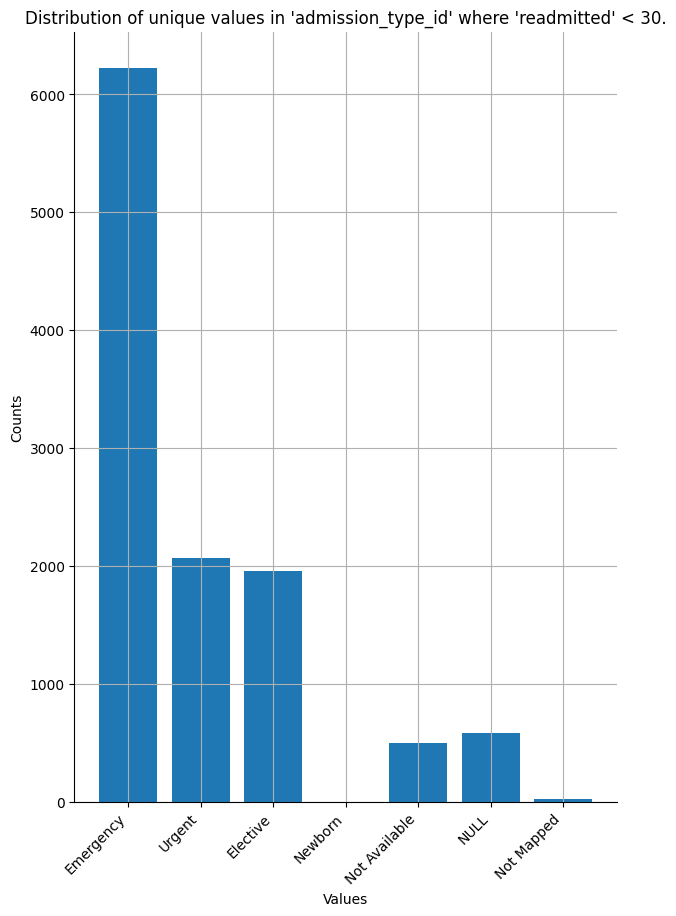

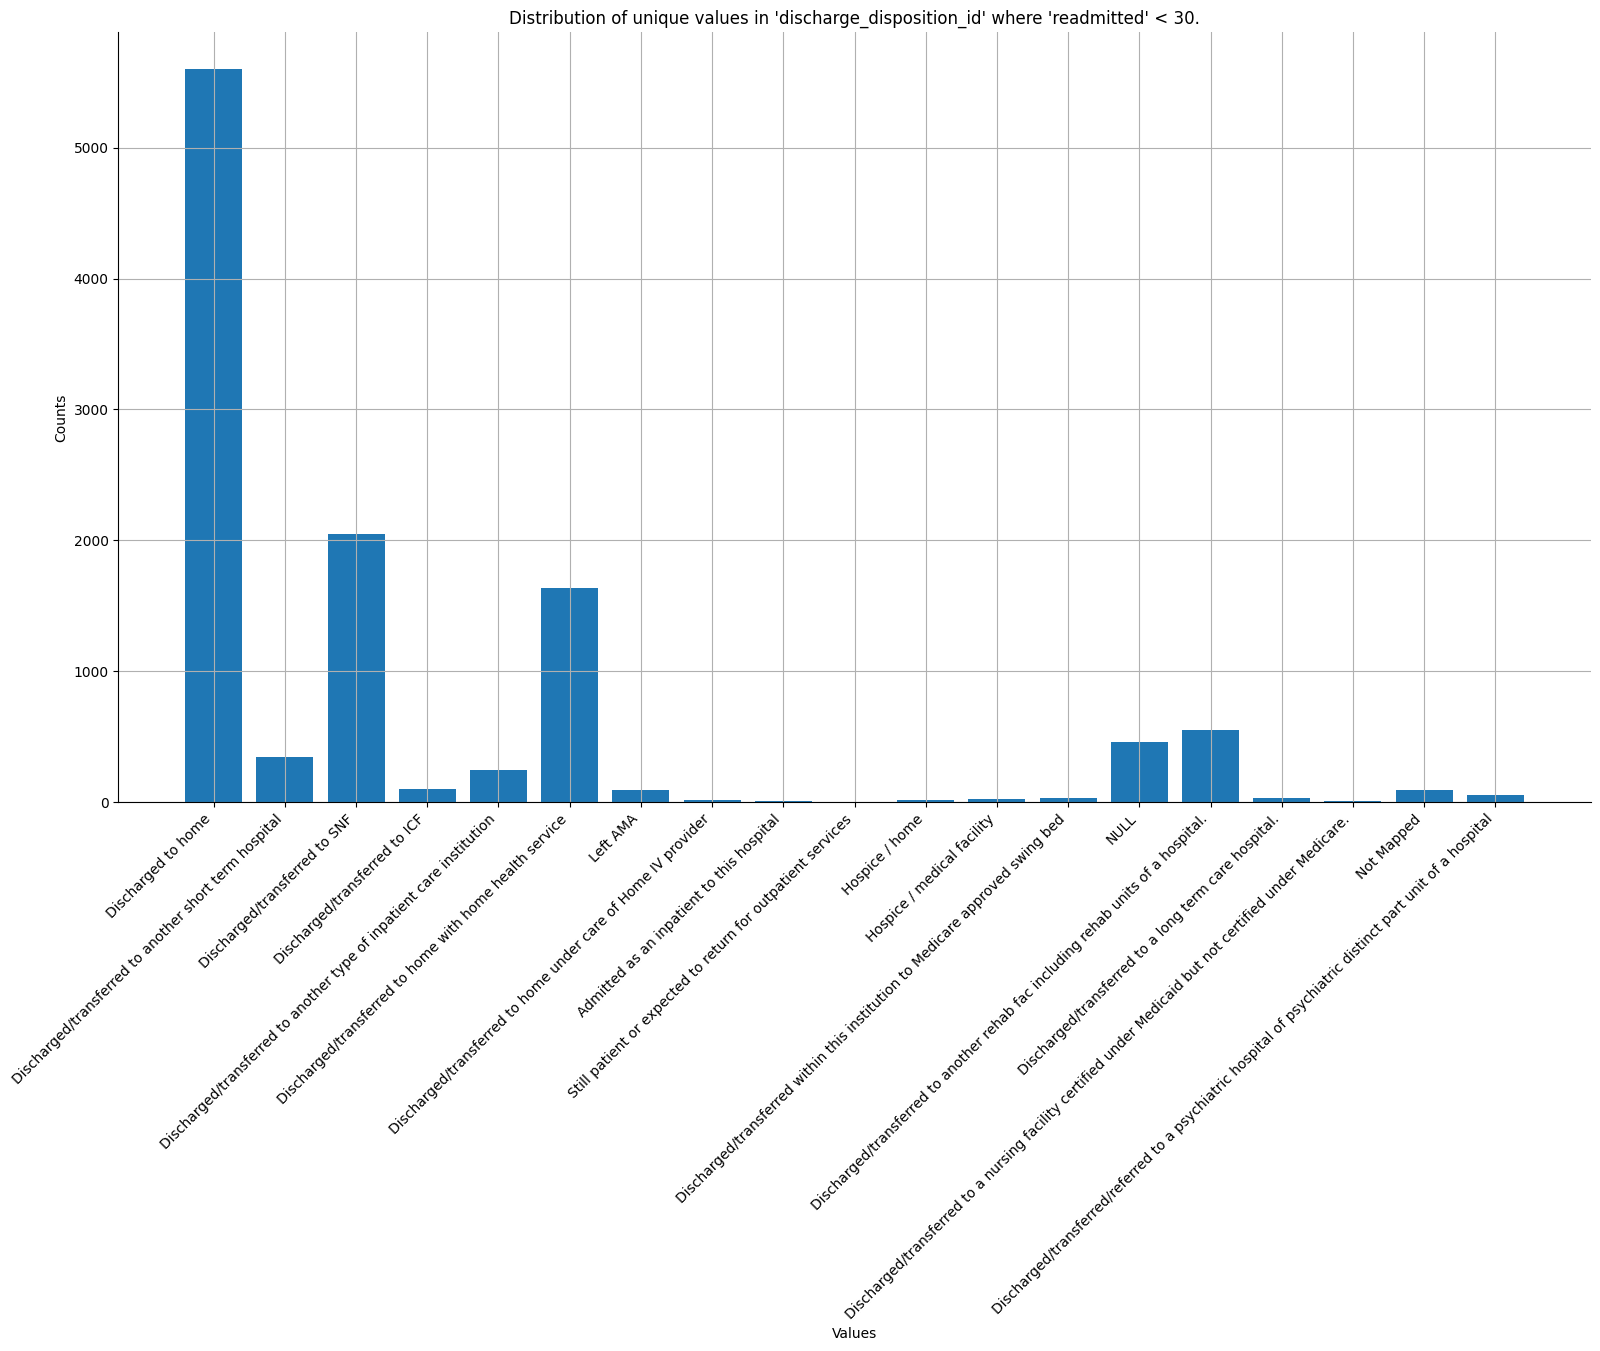

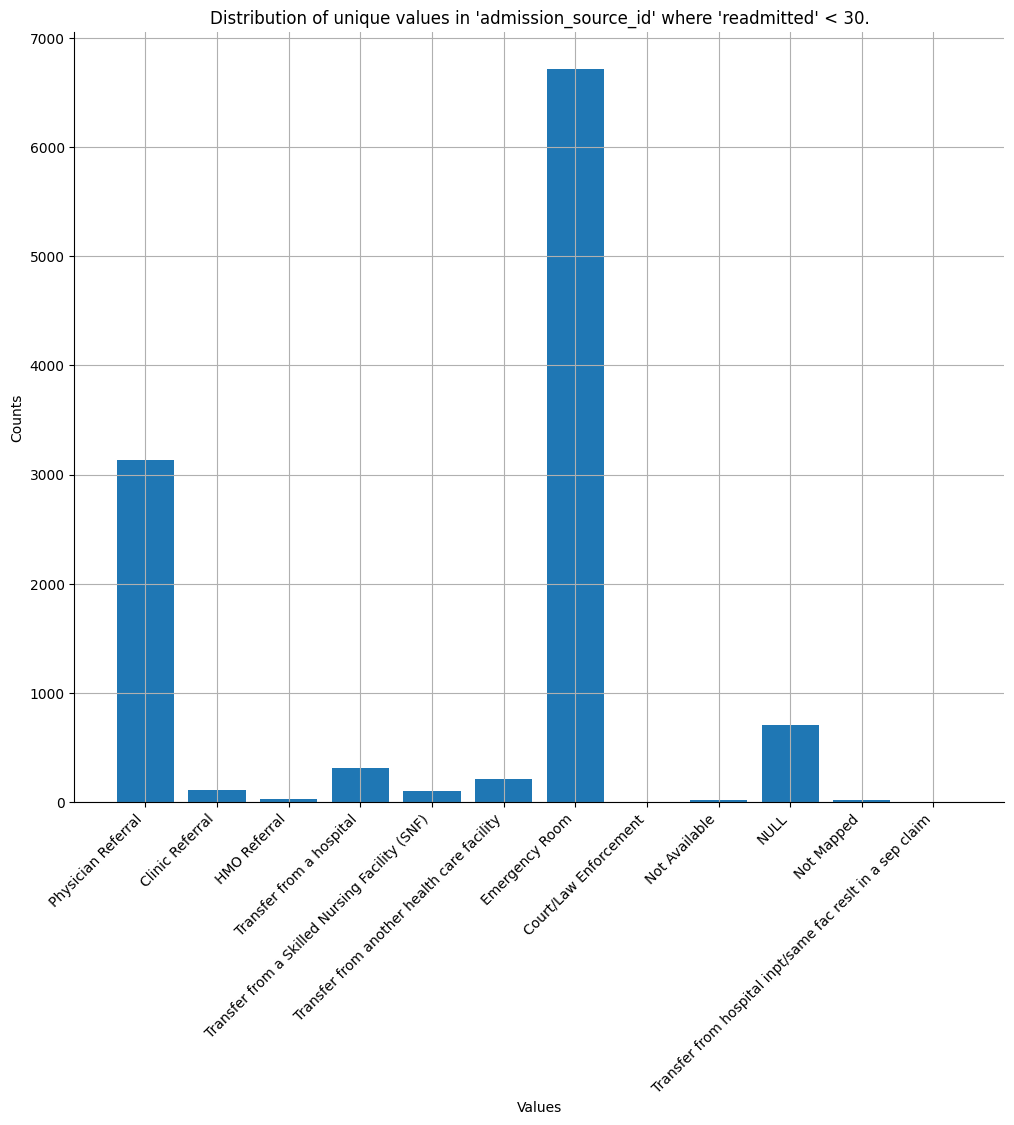

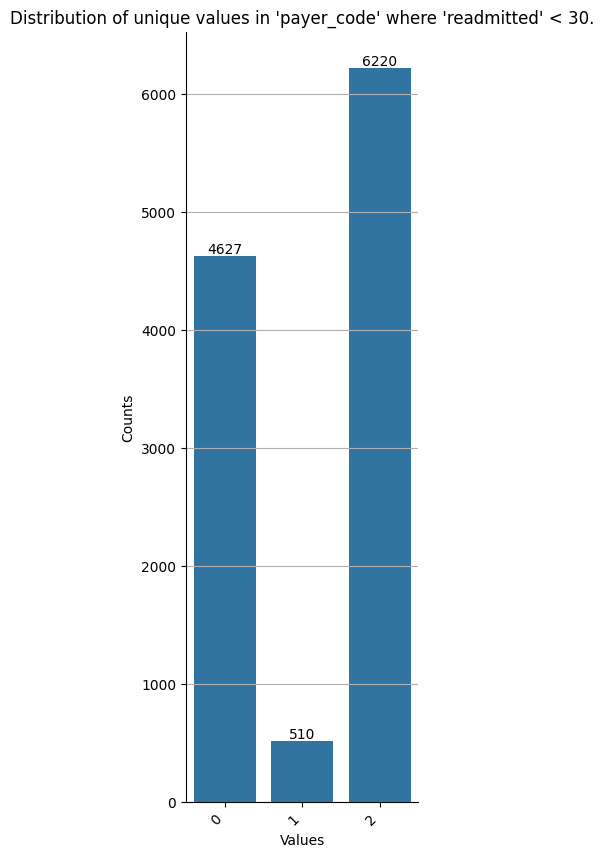

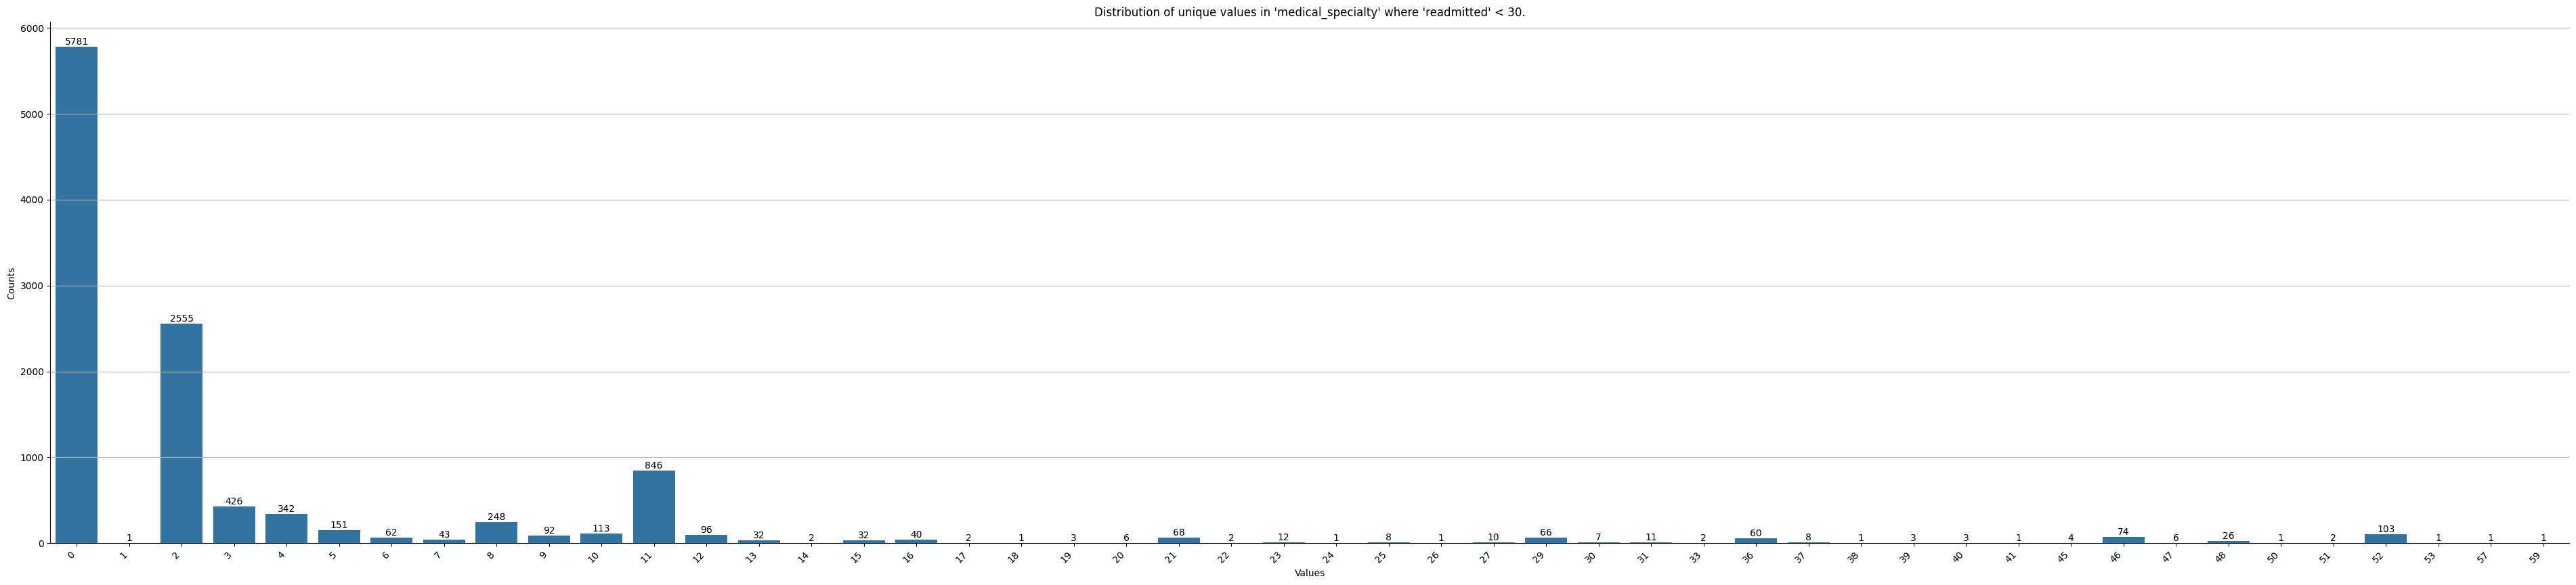

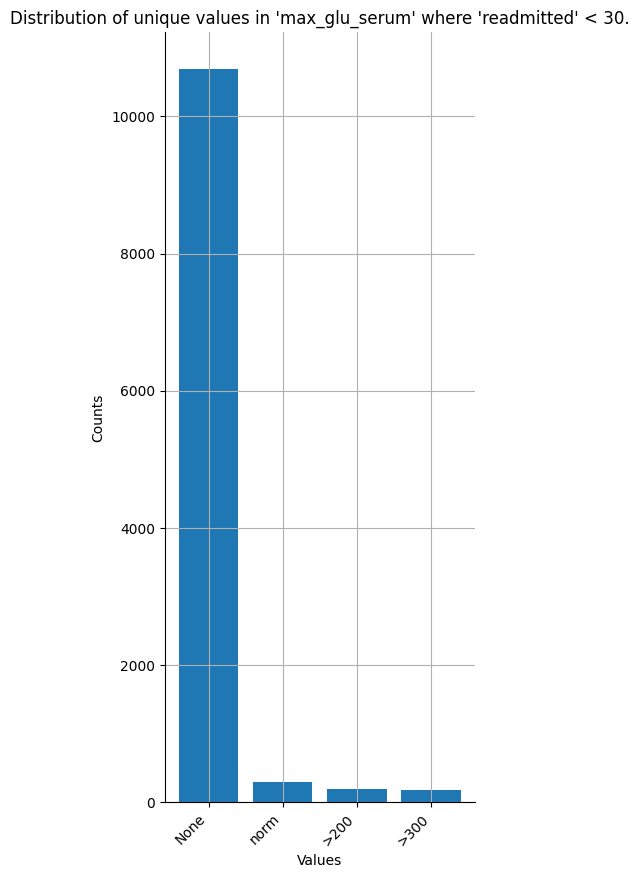

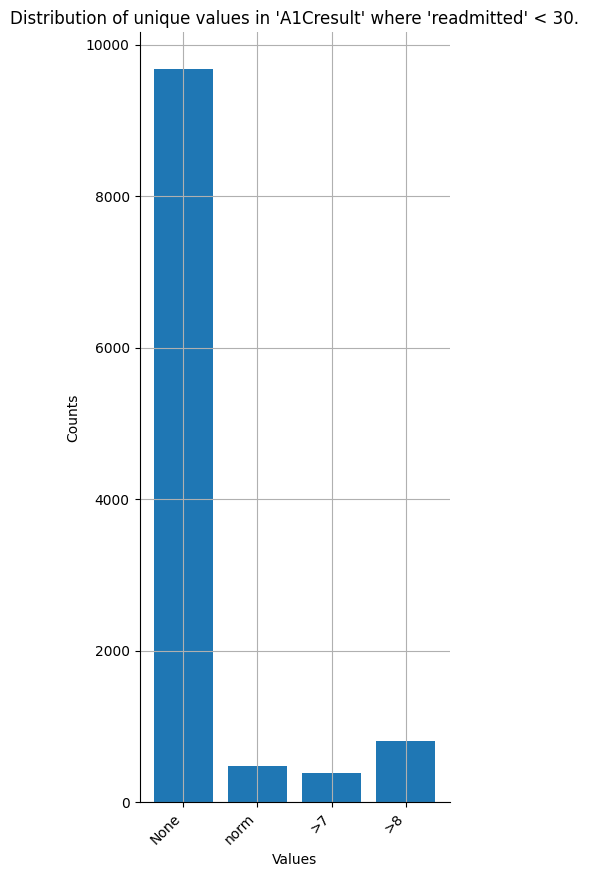

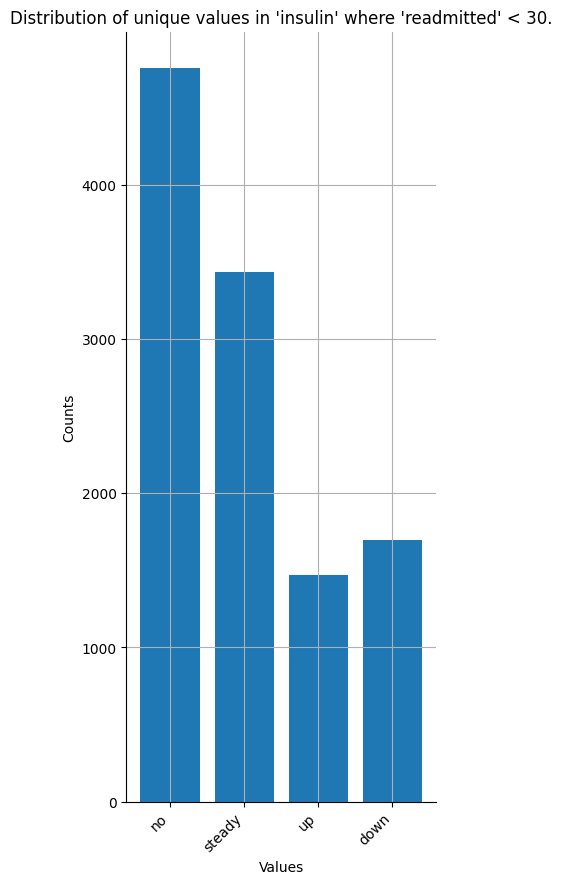

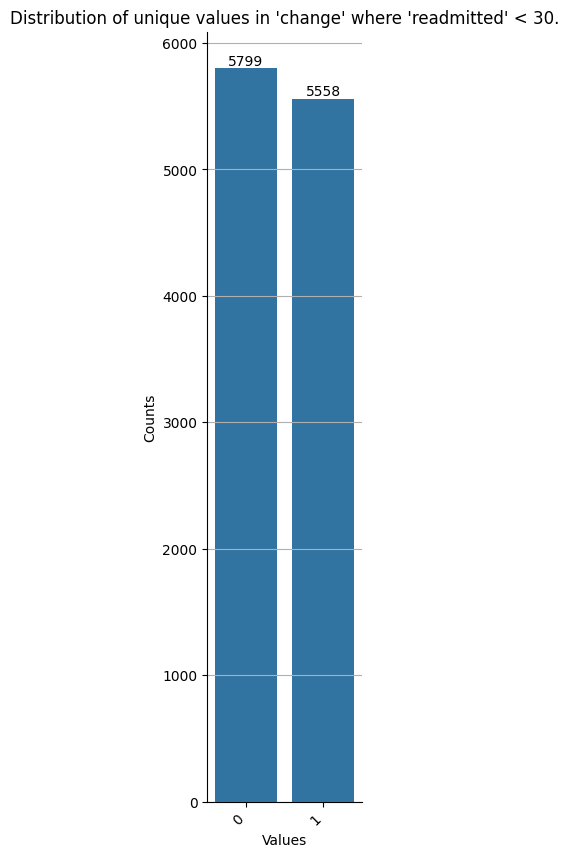

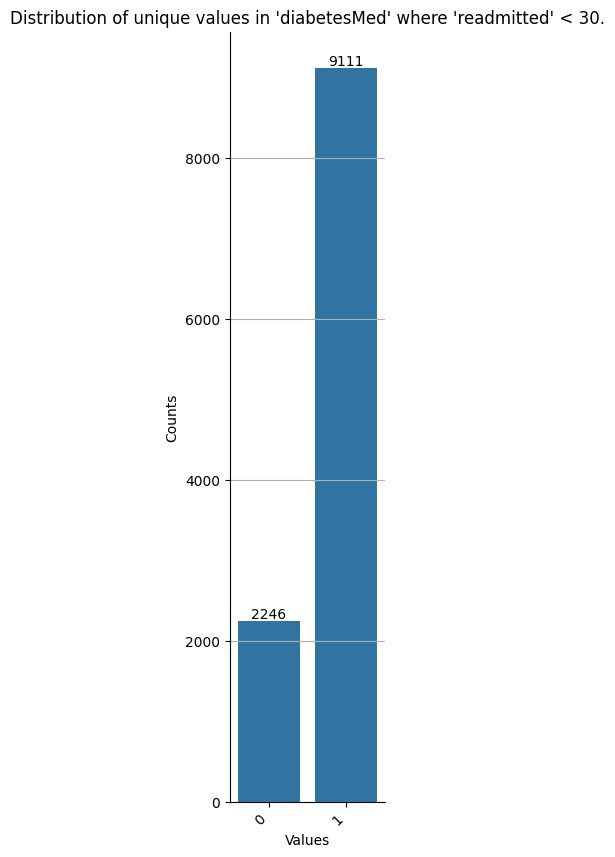

In [46]:
columns_of_interest_categorical = [
    'admission_type_id', 'discharge_disposition_id',
    'admission_source_id', 'payer_code', 'medical_specialty',
    'max_glu_serum', 'A1Cresult', 'insulin', 'change', 'diabetesMed'
    ]

do_basic_analysis_and_charts(columns_of_interest_categorical, 'categorical', df, 45, str(FIG_DIR), subfolder_names[1], column_label_dictionaries)

Like the graphs for some of the numerical columns, the following graphs for some categorical columns were done on a version of dataset that only contains patients who were readmitted within 30 days of their prior visit.

"admission_type_id"
* Right skewed.
* Much of the patients were admitted as emergencies (life-threatening situations that need to be treated immediately). The second and third most common admission reasons were urgent (a variety of medical issues that need to be treated right away but aren't considerd to be true emergencies) and elective (for procedures that can be scheduled in advance).
* This column should be kept, but "Not Available", "NULL", and "Not Mapped" should be binned together under a single "No Information Provided" category.

"discharge_disposition_id"
* Right skewed.
* Much of the patients have the following three discharge disposition ids: "discharged to home", "discharged/transferred to SNF" (skilled nursing facility), and "discharged/transferred to home with home health service". The remaining categories then either occur infrequently or not at all.
* This column should be kept, but careful consideration needs to be done on what outliers are removed and what categories are binned together. Some categories that occur infreqently, such as "left AMA" (against medical advice), are still important and should be kept.

"admission_source_id"
* Somewhat symmetric.
* Much of the patients were admitted either to the emergency room or through a physician's referral (a recommendation from a primary care physician to see a specialist for care that the primary physician doesn't provide).
* This column should be kept but, since many of these categories are important, careful consideration is again needed as to what categories should be binned or removed (if any). However, "Not Available", "NULL", and "Not Mapped" could likely be binned together.

"payer_code"
* Could technically be considered bimodal, although there is only three categories.
* No outliers are present.
* This column should be kept, as patients who don't use insurance are less likely to return for additional treatment.

"medical_specialty"
* Right skewed.
* This column likely needs to be kept, as the type of physicians patients are being admitted to is important. However, given the large number of outliers, it is possible that some physician types may need to be grouped together. If done, this needs to be completed carefully. If we get to a point where certain physicians cannot be grouped together, we may have to use different methods, such as one-hot encoding or target encoding.

"max_glu_serum"
* The graph is right skewed whether or not the "not measured" category is included or not.
* Most patients did not have this glucose test done. Among those who did, there were more patients who had "normal" scores than patients who scored >200 or >300.
* This column should be kept, although careful consideration is need as to whether the "not measured" category is retained or removed. If that category is retained, it is possible that a transformation or assigning weights to classes (in this case, higher weights to the other three categories) may be needed.

"A1Cresult"
* If "not measured" is included, the graph is right skewed. Otherwise, it is left skewed.
* Most patients did not have their average blood sugar (glucose) levels measured. Among those who did, there were more patients whose A1C scores were greater than 8% than not by a considerable margin.
* This column should be kept, although careful consideration is again need as to whether the "not measured" category is retained or removed. The possible solutions mentioned for the "max_glu_serum" column could potentially be applied here as well.

"insulin"
* Right skewed.
* Most patients ether were not perscribed insulin or had their insulin dosages kept the same. However smaller but still notable groups of patients did have their insulin dosages raised or lowered.
* This column should be kept as is.

"change"
* Similar amounts of patients had their diabetic medications changed versus left alone, with more being in the latter. Given that, it may be possible for this column to be omitted from the training and testing dataset. With that said, the model could possibly be run both with and without this column to explore how it affects performance.

"diabetesMed"
* Technically left skewed, but there are only two categories.
* Many more patients who were readmitted were prescribed diabetic medication than not.
* This column should be kept as is.

### BIVARIATE
1. Box plot — time_in_hospital vs readmission

C:\Users\ahswi\AppData\Local\Temp\ipykernel_37836\1059551769.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


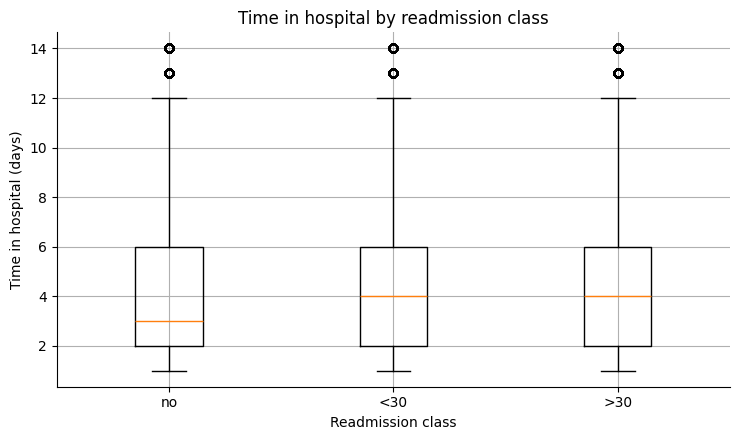

In [47]:
folder_exists, status_string, nested_directory = create_folder(str(FIG_DIR), "boxplot")

if (folder_exists):
    col = "time_in_hospital"
    classes = sorted(df[TARGET].dropna().unique())
    data = [df.loc[df[TARGET]==c, col].dropna().values for c in classes]
    labels = [readmit_map.get(int(c), str(c)) for c in classes]

    plt.figure()
    plt.boxplot(data, labels=labels, showfliers=True)
    plt.title("Time in hospital by readmission class")
    plt.xlabel("Readmission class")
    plt.ylabel("Time in hospital (days)")
    plt.tight_layout()
    plt.savefig(nested_directory + "/box_time_in_hospital_by_readmit.png", dpi=150)
    plt.show()
else:
    output_text_information_to_txt_file(nested_directory + "/Error", status_string)

The length-of-stay distributions for no, <30, and >30 overlap substantially, with no clear median shift. Visually, that implies a small effect size (the difference between classes is small in practical terms). 

We will treat time_in_hospital as a context feature and expect it to be more useful in interactions (a feature becomes informative when combined with another, (e.g., length of stay × prior visits) than as a standalone driver.

2. Relationship among number_outpatient, number_emergency, number_inpatient

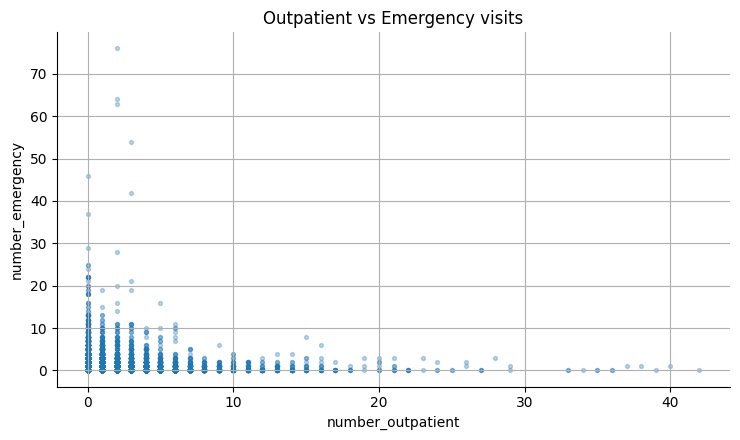

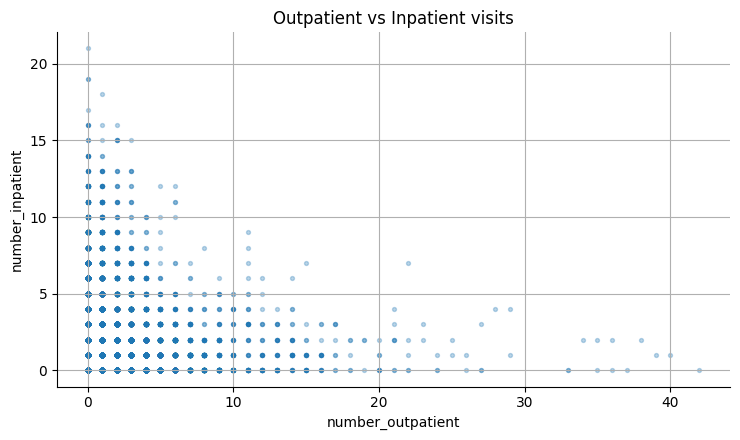

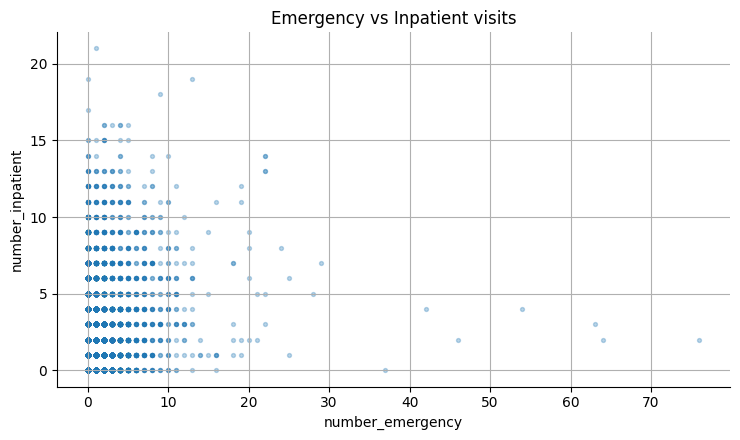

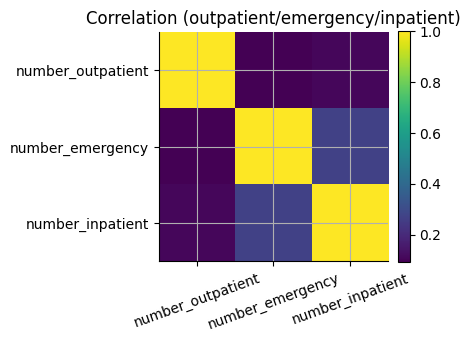

                   number_outpatient  number_emergency  number_inpatient
number_outpatient           1.000000          0.091459          0.107338
number_emergency            0.091459          1.000000          0.266559
number_inpatient            0.107338          0.266559          1.000000


In [48]:
subfolder_name = "scatterplots"

x1, x2, x3 = "number_outpatient", "number_emergency", "number_inpatient"


folder_exists, status_string, nested_directory = create_folder(str(FIG_DIR), subfolder_name)

if (folder_exists):
    # Scatter: outpatient vs emergency
    plt.figure()
    plt.scatter(df[x1], df[x2], s=8, alpha=0.3)
    plt.xlabel(x1); plt.ylabel(x2)
    plt.title("Outpatient vs Emergency visits")
    plt.tight_layout()
    plt.savefig(nested_directory + "/scatter_outpatient_vs_emergency.png", dpi=150)
    plt.show()

    # Scatter: outpatient vs inpatient
    plt.figure()
    plt.scatter(df[x1], df[x3], s=8, alpha=0.3)
    plt.xlabel(x1); plt.ylabel(x3)
    plt.title("Outpatient vs Inpatient visits")
    plt.tight_layout()
    plt.savefig(nested_directory + "/scatter_outpatient_vs_inpatient.png", dpi=150)
    plt.show()

    # Scatter: emergency vs inpatient
    plt.figure()
    plt.scatter(df[x2], df[x3], s=8, alpha=0.3)
    plt.xlabel(x2); plt.ylabel(x3)
    plt.title("Emergency vs Inpatient visits")
    plt.tight_layout()
    plt.savefig(nested_directory + "/scatter_emergency_vs_inpatient.png", dpi=150)
    plt.show()
else:
    output_text_information_to_txt_file(nested_directory + "/Error", status_string)


folder_exists, status_string, nested_directory = create_folder(str(FIG_DIR), subfolder_names[3])

if (folder_exists):
    # Mini heatmap for correlations among the three
    sub = df[[x1, x2, x3]].corr()
    plt.figure(figsize=(4.5, 4))
    im = plt.imshow(sub.values, interpolation="nearest")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(3), sub.columns, rotation=20)
    plt.yticks(range(3), sub.index)
    plt.title("Correlation (outpatient/emergency/inpatient)")
    plt.tight_layout()
    plt.savefig(nested_directory + "/corr_three_counts.png", dpi=150)
    plt.show()

    print(sub)
else:
    output_text_information_to_txt_file(nested_directory + "/Error", status_string)

All three visit counts are zero-inflated (many zeros) with a right tail (a few very large values). Correlations are low to moderate as emergency with inpatient is about 0.27 (the strongest of the three), outpatient with inpatient about 0.11, and outpatient with emergency about 0.09. A correlation is a number between –1 and 1 that measures linear association. Values near 0 indicate weak linear relationships. Because none of these are high, the features are not redundant (each adds different information). 

For modeling, we may apply a log(1+x) transform (compresses large values so extreme cases don’t dominate) or cap (winsorize), meaning we replace values above a chosen cutoff with the cutoff instead of deleting rows, to reduce the influence of outliers.

3. Box Plot - A number of relevant columns vs readmitted.

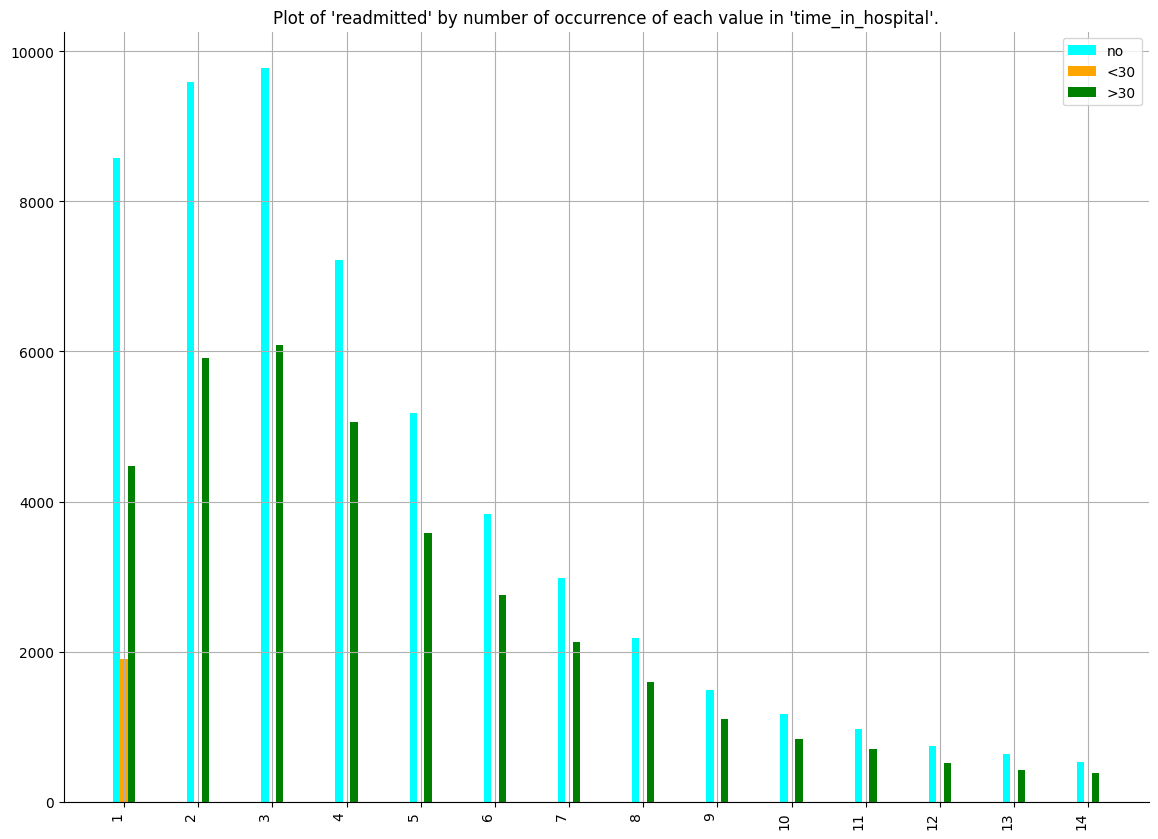

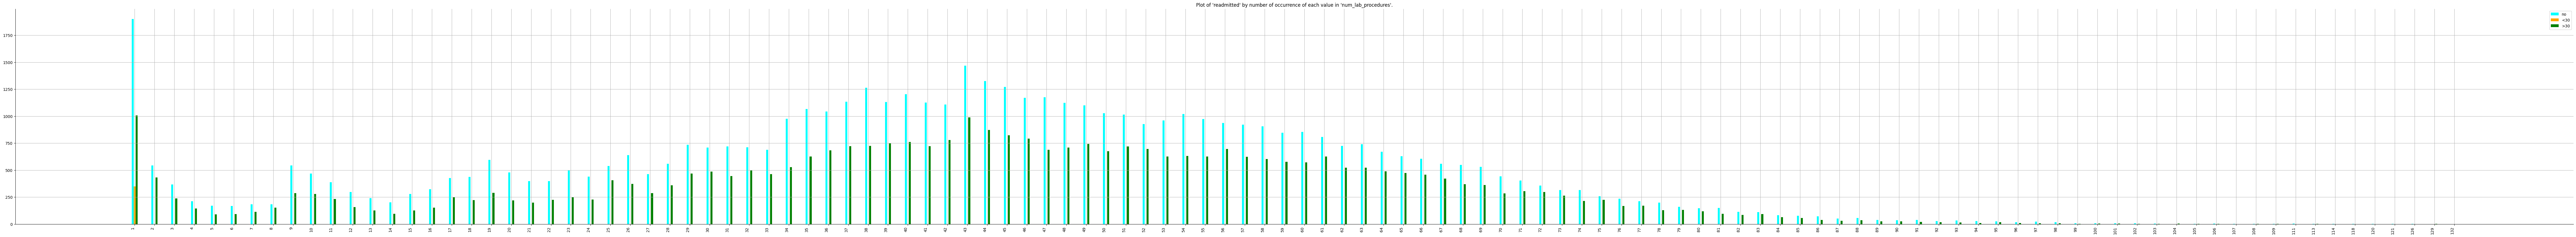

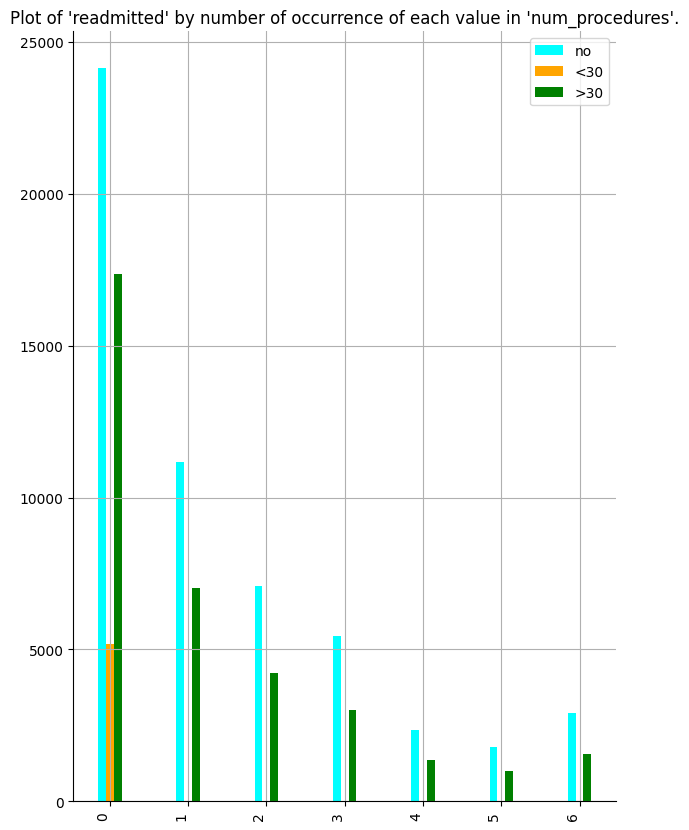

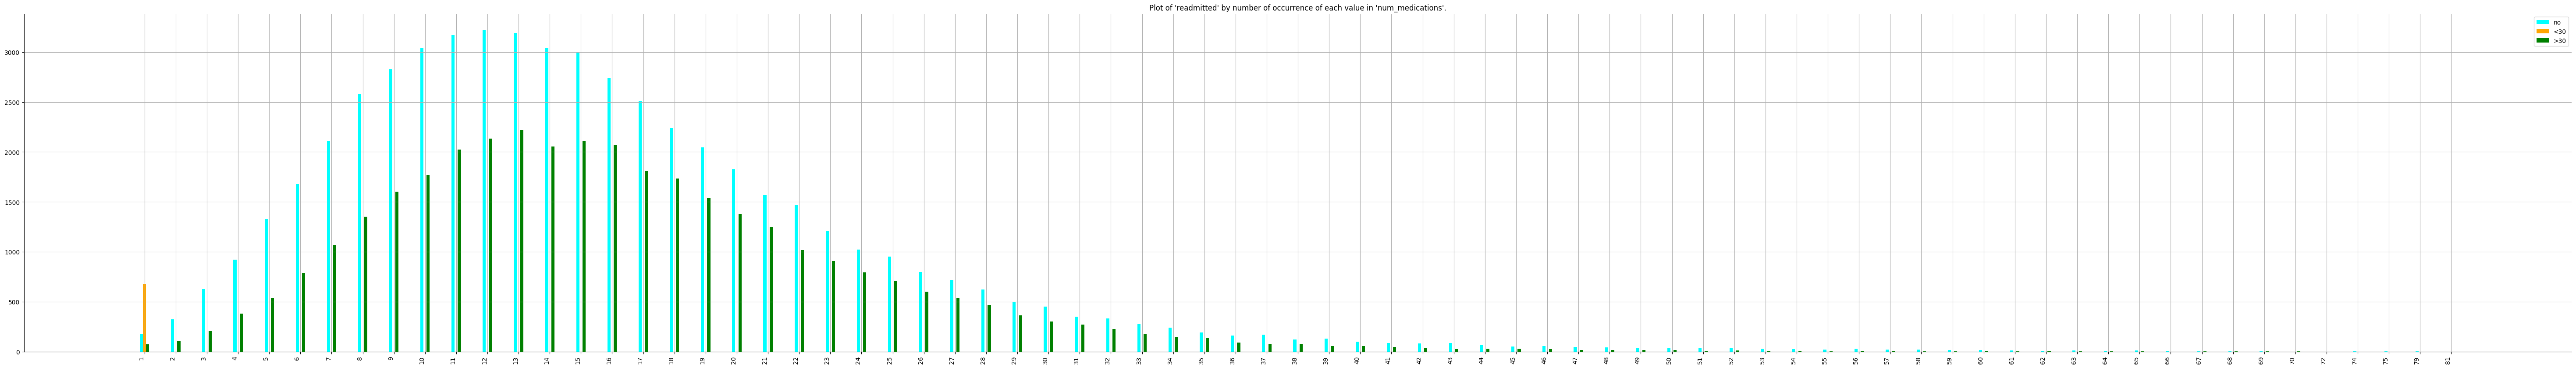

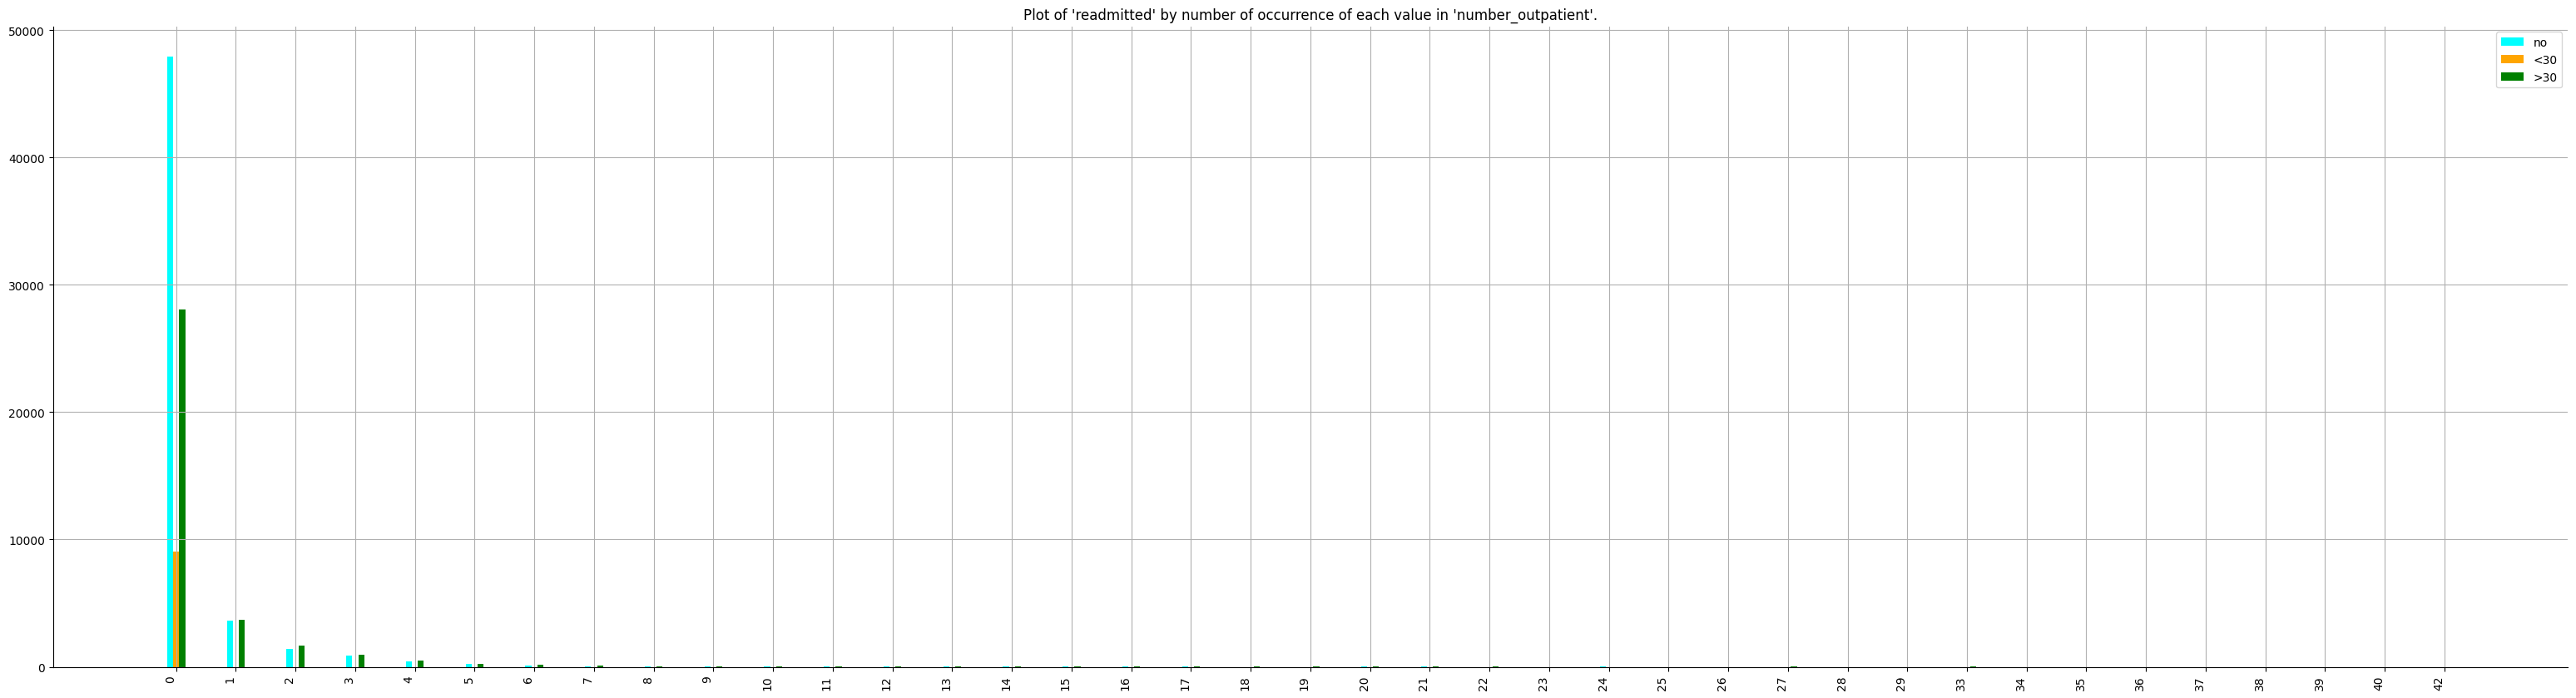

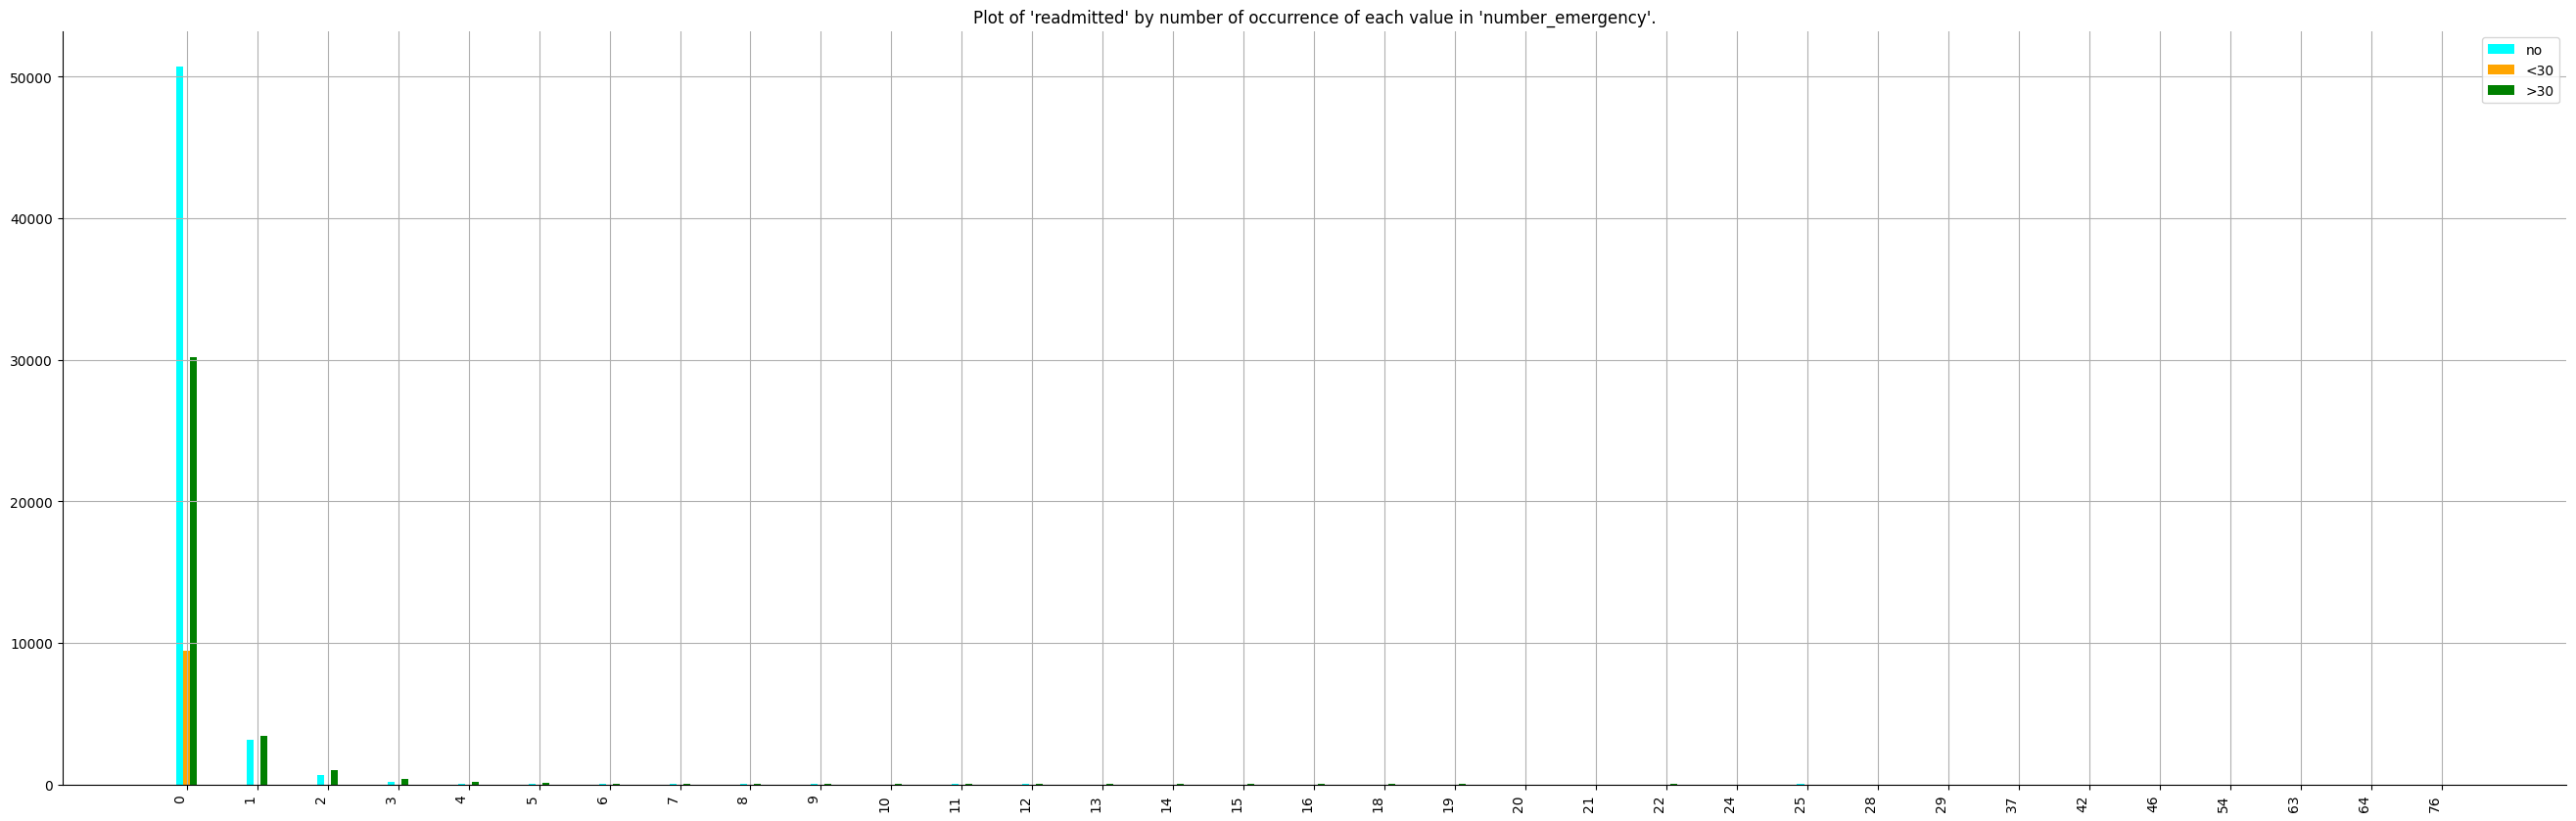

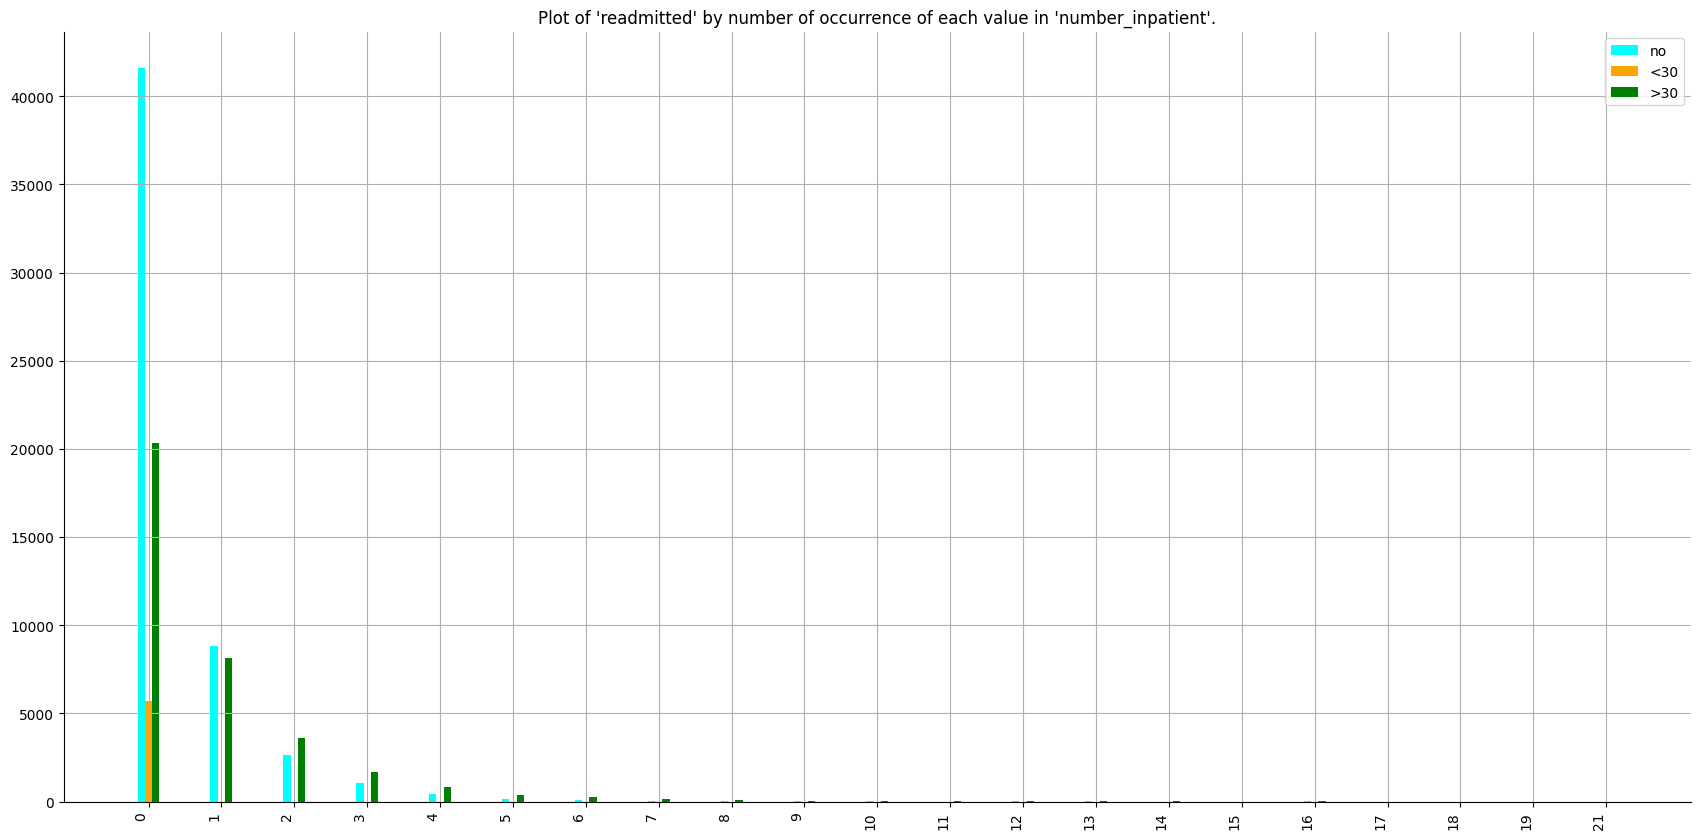

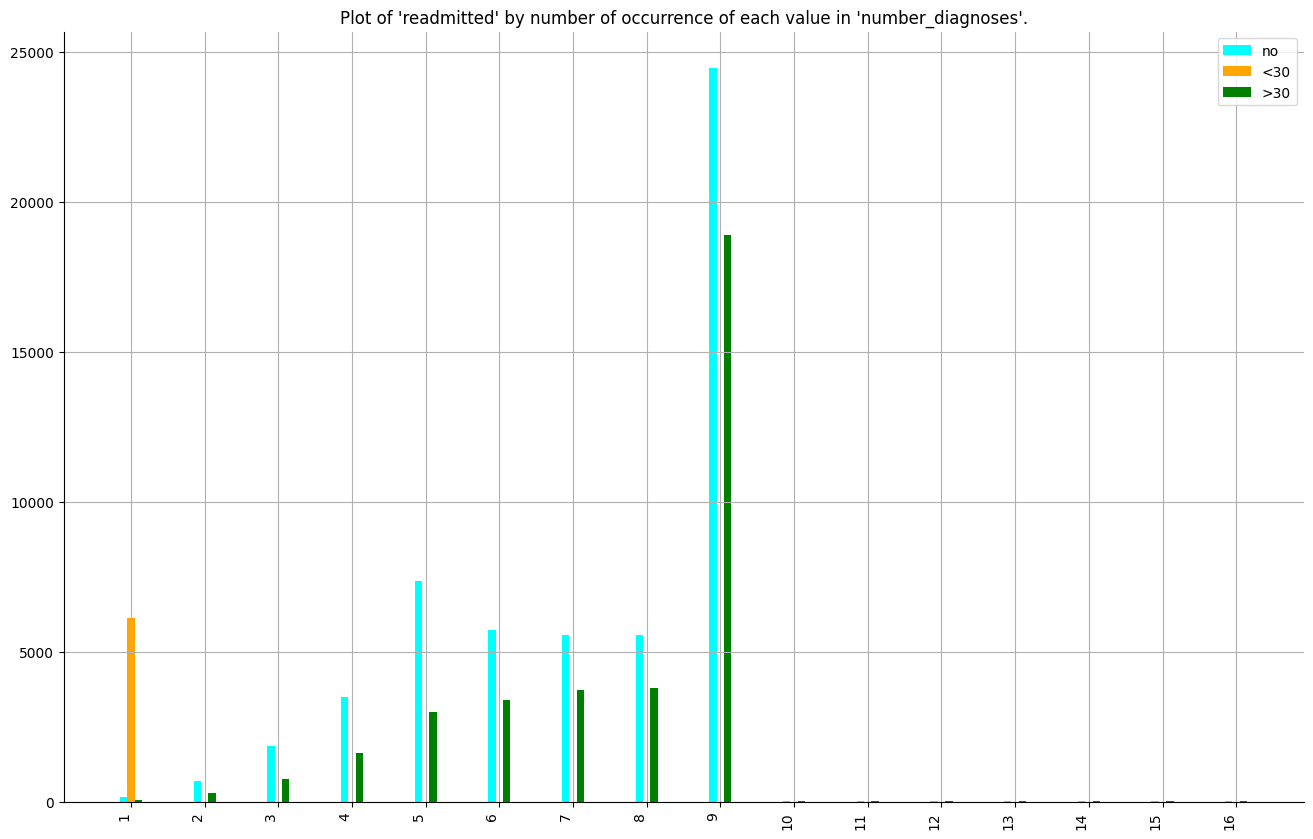

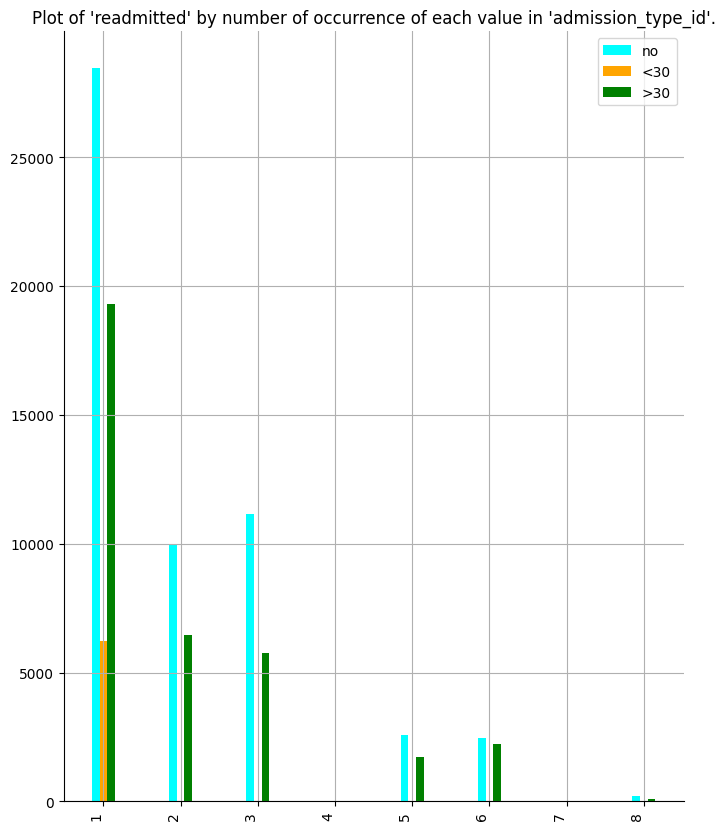

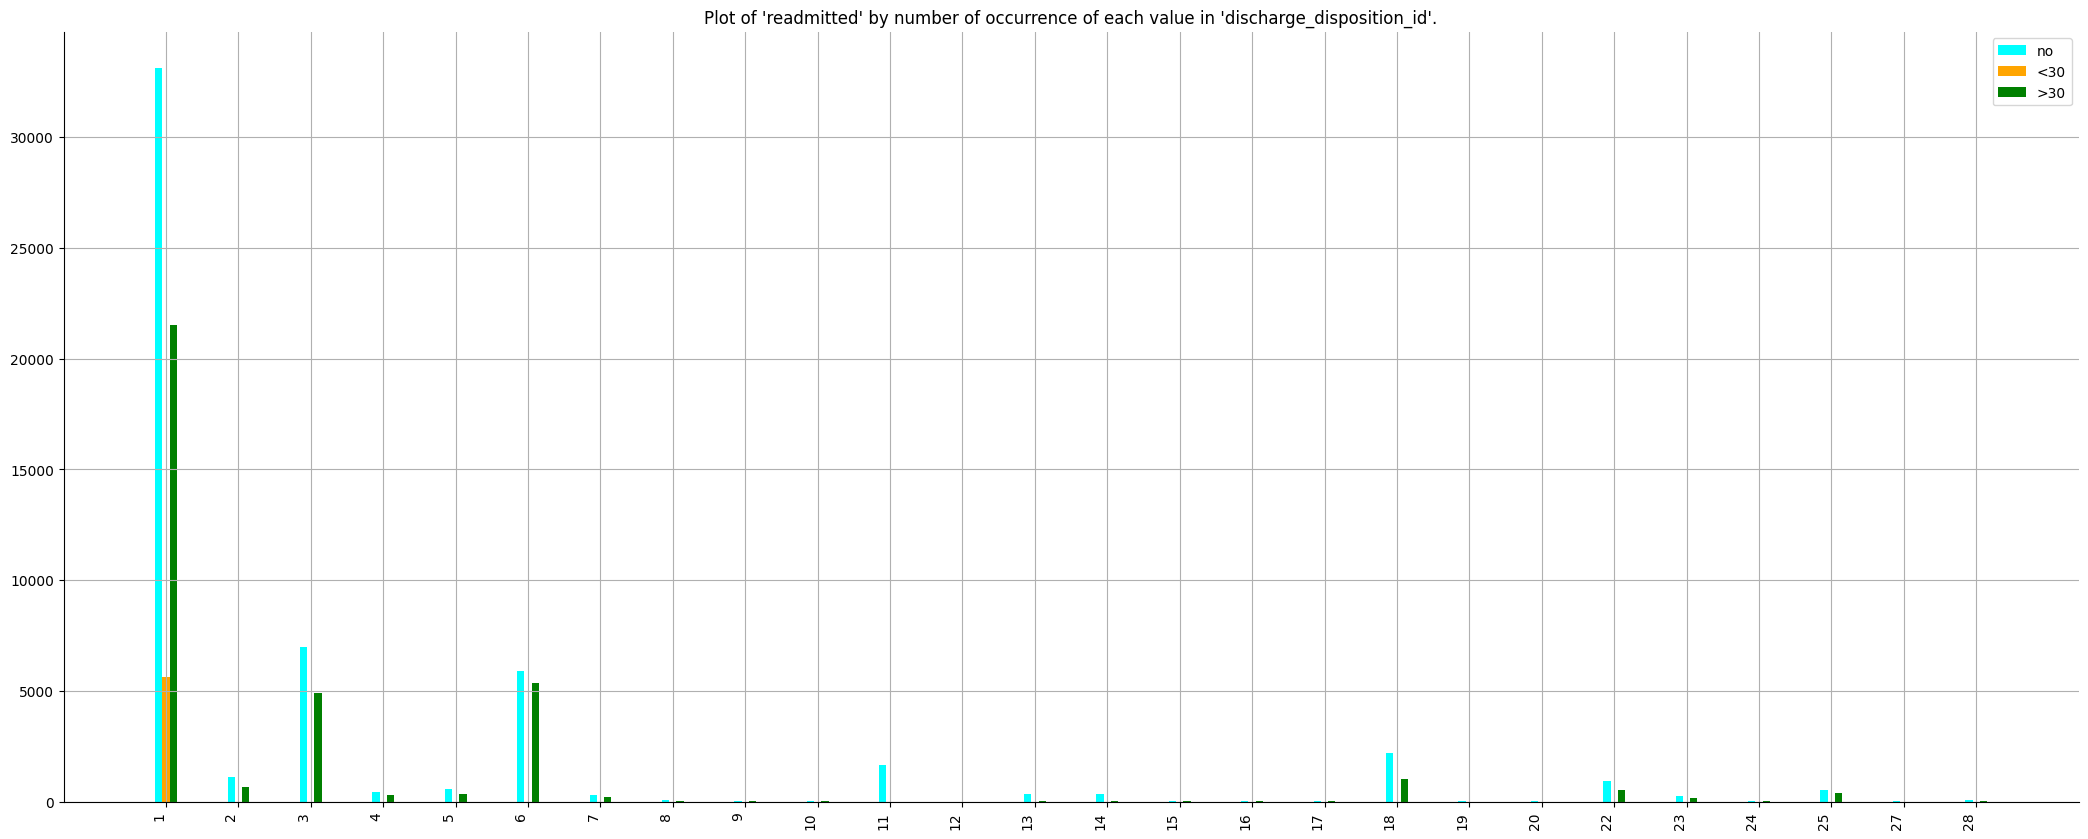

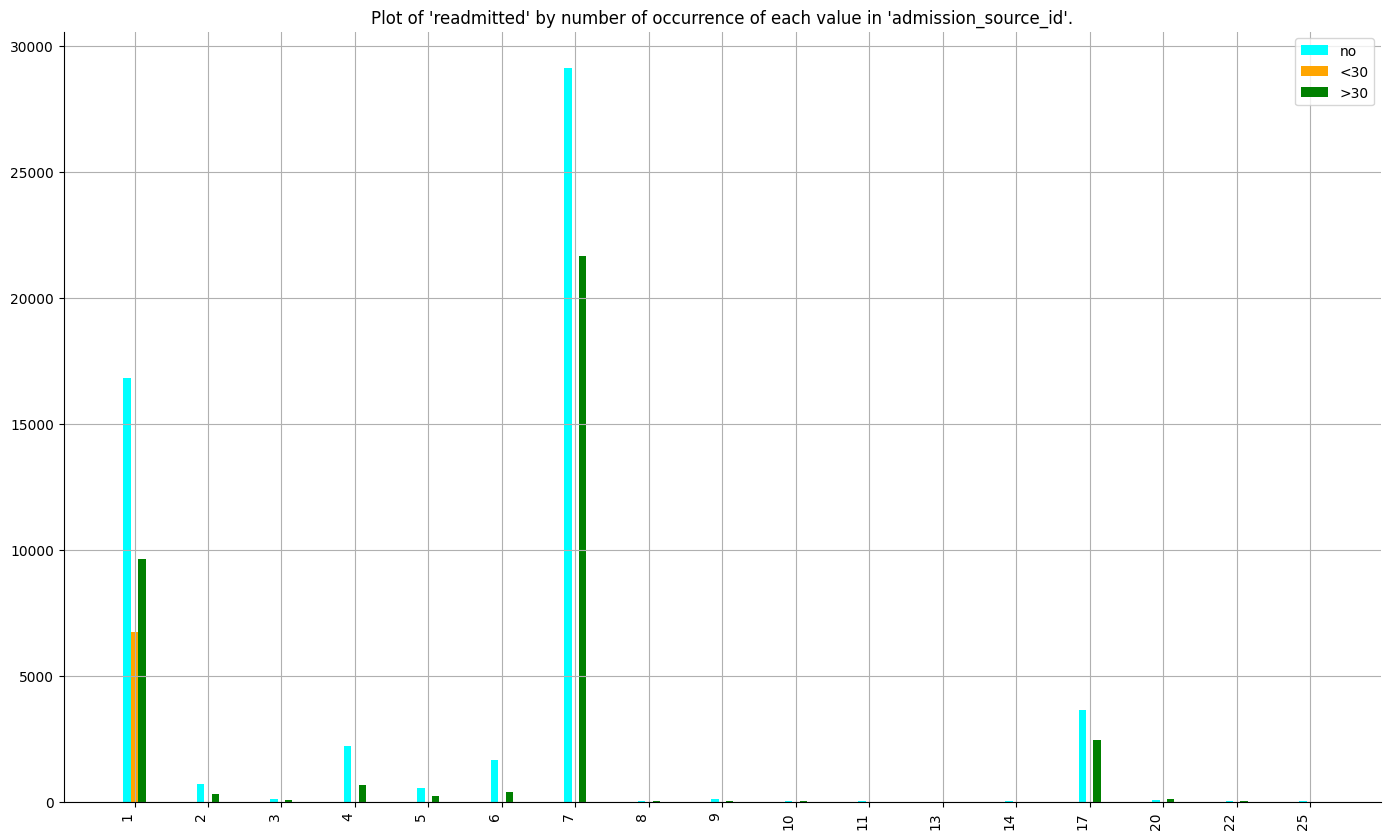

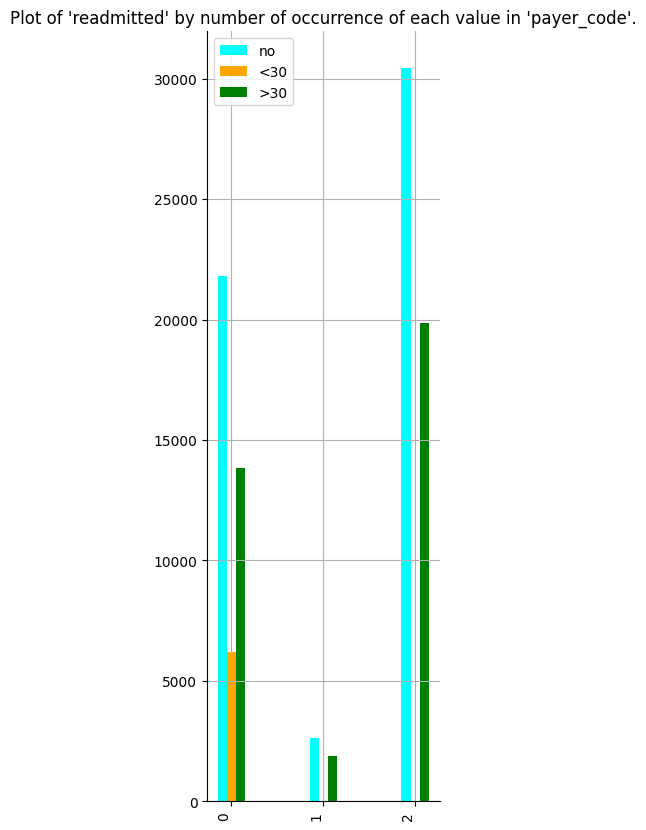

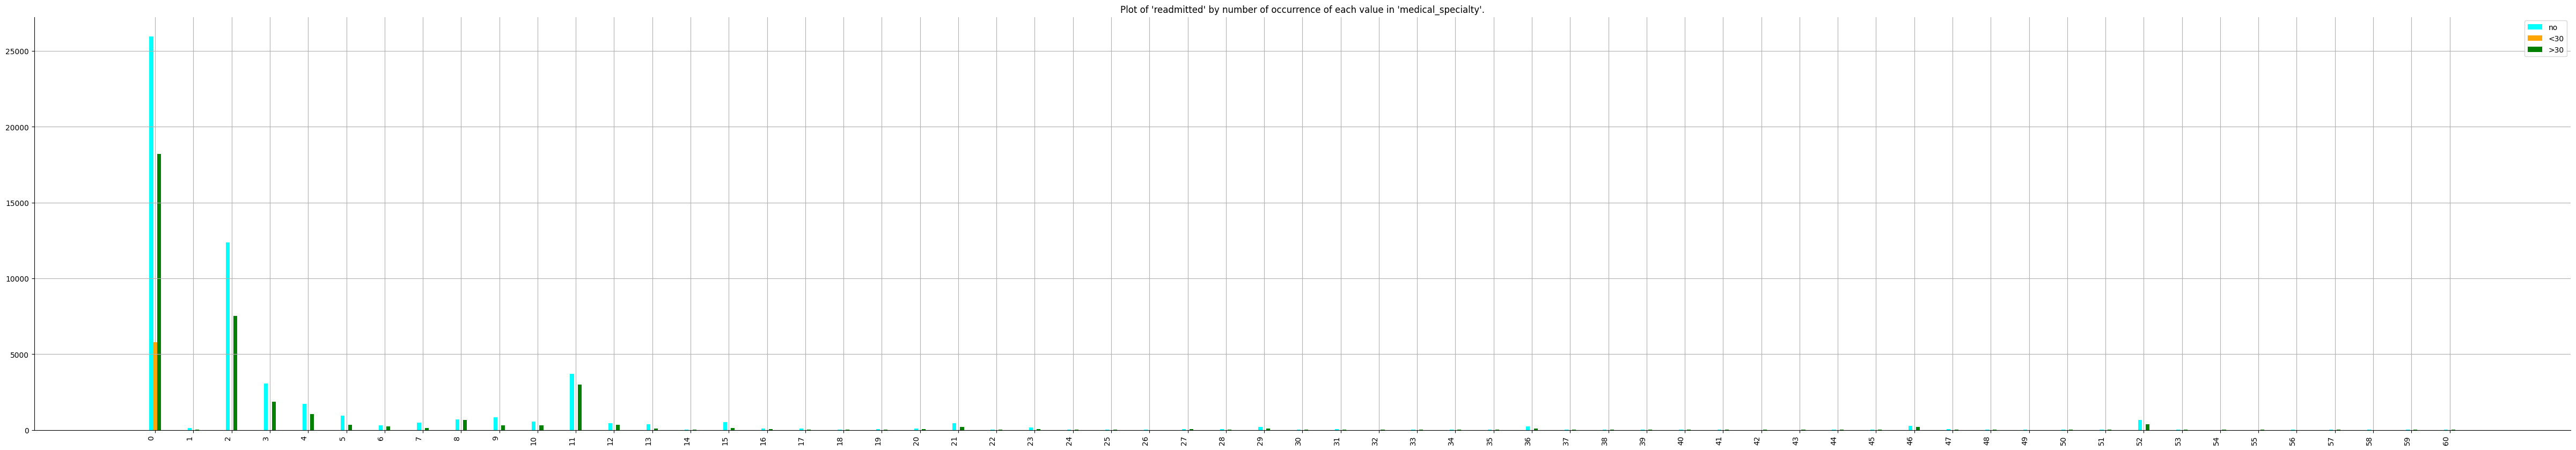

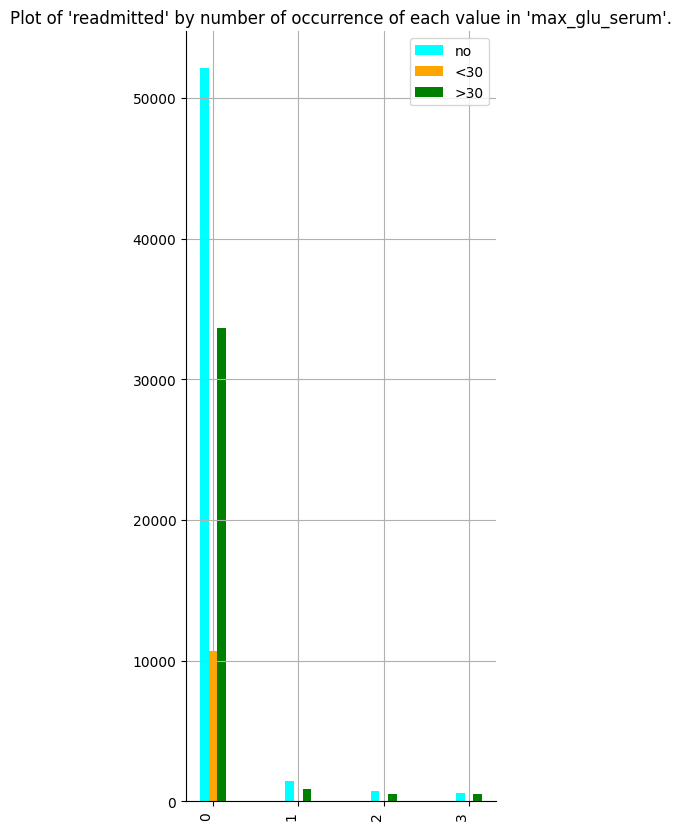

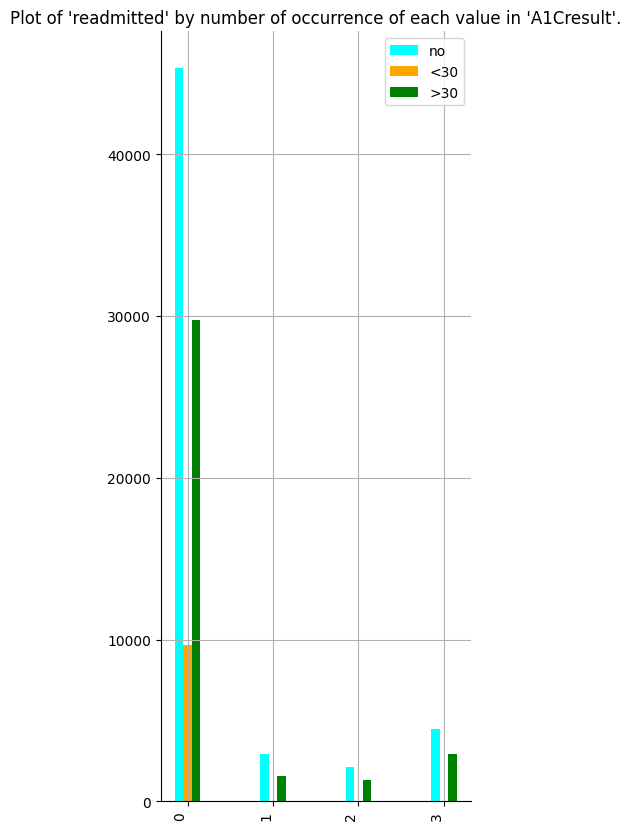

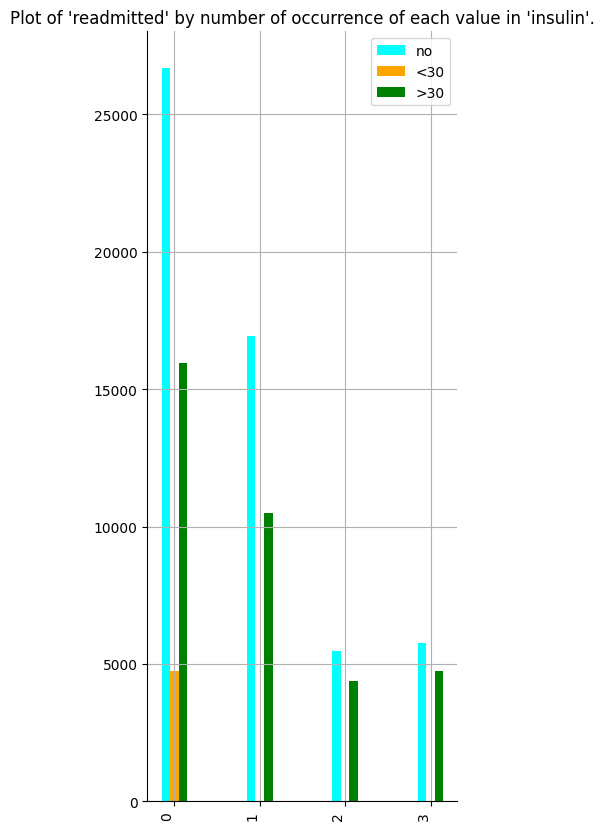

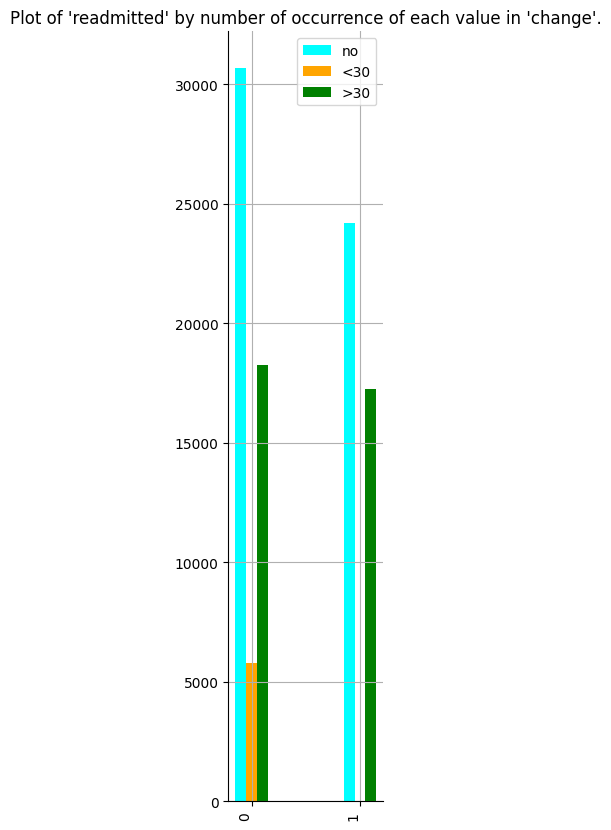

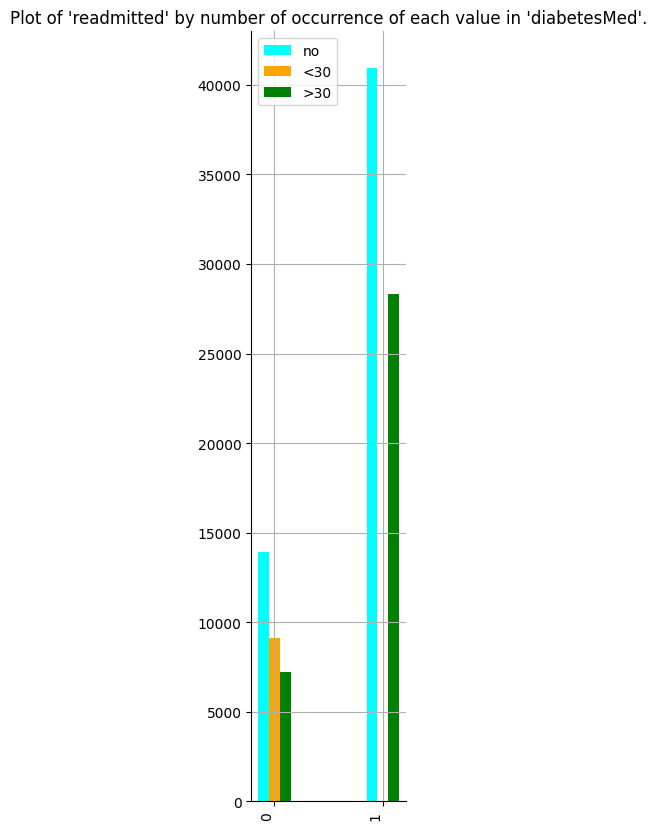

In [49]:
def bar_plot_by_readmitted_categories(df_imported, column_to_group_by_categories, bar_distance_from_center_of_line, bar_width, x_size, y_size, x_label_rotation, dataset_is_grouped, before_edits, nested_directory_and_name, show_plot):
    # Group the dataframe by the 'readmitted' column. After that, unstack the result (rotate the result by the index from rows to columns). Combinations of
    #  values that don't exist will be represented by NaN. Fill in these NaN values with 0, which in our case fills in values that weren't included in
    #  one side of the groupby because their counts for that category are 0. Finally, stack the result again in order to get back to the normal groupby
    #  format, which in our case is the dataframe grouped by the 'readmitted' column's values.
    list_of_column_names = []

    if (dataset_is_grouped == False):
        grouped_churn_count = df_imported.groupby(['readmitted', column_to_group_by_categories]).size().unstack(fill_value=0).stack()

        for idx, _ in grouped_churn_count.items():
            list_of_column_names.append(idx[1])

    else:
        list_of_column_names = df_imported.columns

    unique_list_of_list_of_column_names = []
    for current_item in list_of_column_names:
        if current_item not in unique_list_of_list_of_column_names:
            unique_list_of_list_of_column_names.append(current_item)

    x = np.arange(len(unique_list_of_list_of_column_names))
    plt.figure(figsize=(x_size, y_size))
    if (before_edits == True):
        plt.bar(x-bar_distance_from_center_of_line, grouped_churn_count[0], bar_width, color='cyan', label=readmit_map.get(0))
        plt.bar(0, grouped_churn_count[1], bar_width, color='orange', label=readmit_map.get(1))
        plt.bar(x+bar_distance_from_center_of_line, grouped_churn_count[2], bar_width, color='green', label=readmit_map.get(2))
    else:
        # Check variables.
        plt.bar(x-bar_distance_from_center_of_line, grouped_churn_count[0], bar_width, color='red', label='>30 or no')
        plt.bar(x+bar_distance_from_center_of_line, grouped_churn_count[1], bar_width, color='blue', label='<30')
    plt.title(f"Plot of 'readmitted' by number of occurrence of each value in '{column_to_group_by_categories}'.")
    plt.xticks(x, unique_list_of_list_of_column_names, rotation=x_label_rotation, ha='right')
    plt.legend()
    if (show_plot):
        plt.show()
    plt.savefig(nested_directory_and_name, dpi=150)
    plt.close()

    return grouped_churn_count


def plot_number_occurrences_per_readmitted_values(df_imported, bar_distance_from_center_of_line, bar_width, y_size, x_label_rotation, dataset_is_grouped, before_edits, folder_location, folder_name, columns_of_interest):
    folder_exists, status_string, nested_directory = create_folder(folder_location, folder_name)

    grouped_churn_count = None

    temp_reduced_df = df_imported[columns_of_interest]
    column_names_list = temp_reduced_df.columns
    
    if (folder_exists):
        current_image_count = 0

        for element in column_names_list:
            nested_directory_and_name = nested_directory + "/" + element + "_" + str(current_image_count) + ".png"

            if ((element != "encounter_id") and (element != "patient_nbr") and (element != "readmitted")):
                chart_width = temp_reduced_df[element].nunique()
                
                if (chart_width > 200):
                    chart_width = 200

                show_plot = False
                if (element in columns_of_interest):
                    show_plot = True
                
                grouped_churn_count = bar_plot_by_readmitted_categories(temp_reduced_df, element, bar_distance_from_center_of_line, bar_width, chart_width, y_size, x_label_rotation, dataset_is_grouped, before_edits, nested_directory_and_name, show_plot)

                current_image_count += 1
        
                output_text_information_to_txt_file("text_information_from_data_check_on_columns", status_string + "\n\n\n" + str(grouped_churn_count))
    else:
        output_text_information_to_txt_file(nested_directory + "/Error", status_string)


columns_of_interest = [
    'readmitted',
    'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
    'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses',
    'admission_type_id', 'discharge_disposition_id',
    'admission_source_id', 'payer_code', 'medical_specialty',
    'max_glu_serum', 'A1Cresult', 'insulin', 'change', 'diabetesMed'
    ]
plot_number_occurrences_per_readmitted_values(df, 0.1, 0.1, 10, 90, False, True, str(FIG_DIR), subfolder_names[0], columns_of_interest)

4. Correlations between the numerical columns in the dataset.

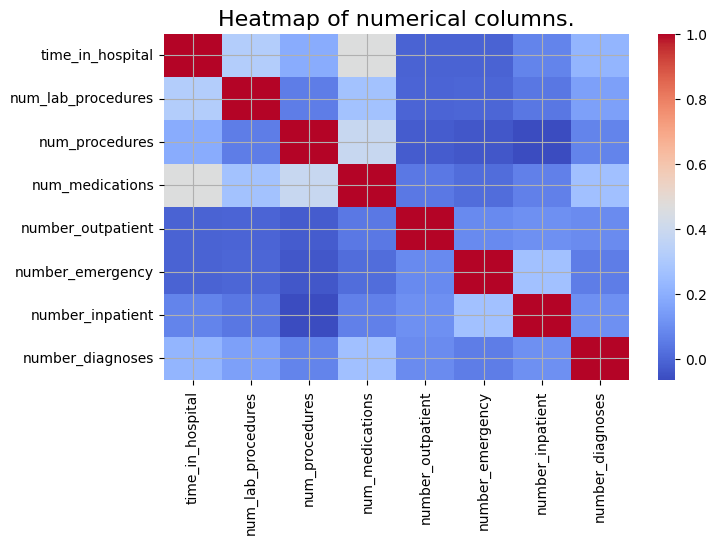

                    time_in_hospital  num_lab_procedures  num_procedures  num_medications  number_outpatient  number_emergency  \
time_in_hospital            1.000000            0.318450        0.191472         0.466135          -0.008916         -0.009681   
num_lab_procedures          0.318450            1.000000        0.058066         0.268161          -0.007602         -0.002279   
num_procedures              0.191472            0.058066        1.000000         0.385767          -0.024819         -0.038179   
num_medications             0.466135            0.268161        0.385767         1.000000           0.045197          0.013180   
number_outpatient          -0.008916           -0.007602       -0.024819         0.045197           1.000000          0.091459   
number_emergency           -0.009681           -0.002279       -0.038179         0.013180           0.091459          1.000000   
number_inpatient            0.073623            0.039231       -0.066236         0.064194 

In [50]:
def create_correlation_heatmap(df_imported, columns_in_question_numerical, folder_location, folder_name):
    folder_exists, status_string, nested_directory = create_folder(folder_location, folder_name)

    nested_directory_and_name = nested_directory + "/created_heatmap.png"

    if (folder_exists):
        current_column_correlation = df_imported[columns_in_question_numerical].corr()
        sns.heatmap(current_column_correlation, cmap="coolwarm")
        plt.title(f"Heatmap of numerical columns.", fontsize=16)
        plt.show()
        plt.savefig(nested_directory_and_name, dpi=150)
        plt.close()

        print(current_column_correlation)
    else:
        output_text_information_to_txt_file(nested_directory + "/Error", status_string)


create_correlation_heatmap(df, columns_in_question_numerical, str(FIG_DIR), subfolder_names[3])

5. A1C result vs readmission rate (highlight >8)

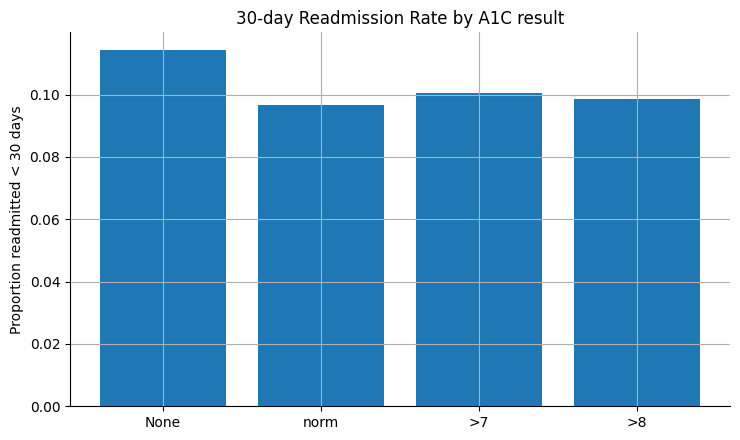

A1Cresult
0    0.114233
1    0.096593
2    0.100472
3    0.098710
Name: readmitted, dtype: float64


In [51]:
folder_exists, status_string, nested_directory = create_folder(str(FIG_DIR), subfolder_names[8])

if (folder_exists):
    col = "A1Cresult"
    tmp = df[[col, TARGET]].dropna()
    rate = (tmp[TARGET] == 1).groupby(tmp[col]).mean()

    # order by the encoded meaning: 0=None, 1=norm, 2=>7, 3=>8
    order = [0, 1, 2, 3]
    rate = rate.reindex(order)
    labels = [a1c_map.get(k, str(k)) for k in rate.index]

    plt.figure()
    bars = plt.bar(labels, rate.values)
    plt.title("30-day Readmission Rate by A1C result")
    plt.ylabel("Proportion readmitted < 30 days")
    plt.tight_layout()
    plt.savefig(nested_directory + "/rate_readmit_lt30_by_A1C.png", dpi=150)
    plt.show()

    print(rate)
else:
    output_text_information_to_txt_file(nested_directory + "/Error", status_string)

The <30 rates by A1C are None 11.42%, norm 9.66%, >7 10.05%, >8 9.87%. “None” (no A1C recorded) is worse than “norm,” and >7 is similar to >8. This is informative missingness (the fact that a value is missing carries information about risk) so we will add a missing indicator (a 0/1 flag that A1C is missing) and we will not merge “None” with “normal.”

6. Insulin usage vs readmission rate

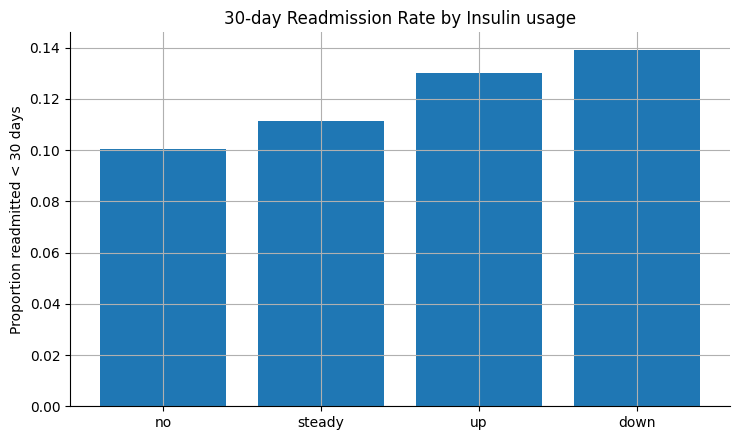

insulin
0    0.100374
1    0.111284
2    0.129905
3    0.138975
Name: readmitted, dtype: float64


In [52]:
folder_exists, status_string, nested_directory = create_folder(str(FIG_DIR), subfolder_names[8])

if (folder_exists):
    col = "insulin"
    tmp = df[[col, TARGET]].dropna()
    rate = (tmp[TARGET] == 1).groupby(tmp[col]).mean()

    # Show in logical order: no, steady, up, down
    order = [0, 1, 2, 3]
    rate = rate.reindex(order)
    labels = [insulin_map.get(k, str(k)) for k in rate.index]

    plt.figure()
    plt.bar(labels, rate.values)
    plt.title("30-day Readmission Rate by Insulin usage")
    plt.ylabel("Proportion readmitted < 30 days")
    plt.tight_layout()
    plt.savefig(nested_directory + "/rate_readmit_lt30_by_insulin.png", dpi=150)
    plt.show()


    print(rate)
else:
    output_text_information_to_txt_file(nested_directory + "/Error", status_string)

There is a clear gradient (ordered pattern) like no 10.04% < steady 11.13% < up 12.99% ≈ down 13.90%. Changes in insulin (up or down) likely reflect clinical instability or disease severity, which tracks with higher <30. Insulin status is therefore a strong clinical signal. 

Alongside the four-level variable, we will create a simple derived flag insulin_changed that is 1 if the state is up or down, else 0.

7. Violinplots 

In [53]:
def do_violinplots(columns_in_question_numerical, columns_in_question_categorical, df_imported, x_label_rotation, folder_location, folder_name):
    folder_exists, status_string, nested_directory = create_folder(folder_location, folder_name)

    combined_list = [*columns_in_question_numerical, *columns_in_question_categorical]
    temp_reduced_df = df_imported[combined_list]

    if (folder_exists):
        current_image_count = 0
        
        for element_1 in columns_in_question_categorical:
            chart_width_1, _ = get_chart_width(temp_reduced_df, element_1, 100)
            
            for element_2 in columns_in_question_numerical:
                if (element_1 != element_2):
                    chart_width_2, _ = get_chart_width(temp_reduced_df, element_2, 40)

                    nested_directory_and_name = nested_directory + "/" + element_1 + "_" + element_2 + "_" + str(current_image_count) + ".png"

                    plt.figure(figsize=(chart_width_1, chart_width_2))
                    sns.violinplot(x = element_1, y = element_2, data = temp_reduced_df)
                    plt.xticks(rotation=x_label_rotation, ha='right')
                    plt.savefig(nested_directory_and_name, dpi=150)
                    plt.close()

                    current_image_count += 1
    else:
        output_text_information_to_txt_file(nested_directory + "/Error", status_string)


columns_of_interest_numerical = ['time_in_hospital', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
columns_of_interest_categorical = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'payer_code', 'max_glu_serum', 'A1Cresult', 'insulin', 'change', 'diabetesMed']

do_violinplots(columns_of_interest_numerical, columns_of_interest_categorical, df, 90, str(FIG_DIR), subfolder_names[5])

Violinplots are a combination of a boxplot and a kernel density plot. They are used to compare the distribution of data between groups. The width of a violin plot at a given region corresponds to the approximate frequency of data points in that region. A wider area means that more points are in that region.

Given the size the violinplots needed to be to be legible, they were not displayed here. However, they can be found in a "violinplots" folder that this file generates.

8. Pairplot

In [54]:
def do_pairplot(columns_in_question, df_imported, x_label_rotation, folder_location, folder_name):
    folder_exists, status_string, nested_directory = create_folder(folder_location, folder_name)

    if (folder_exists):
        max_chart_width = -1
        
        for element in columns_in_question:
            chart_width, _ = get_chart_width(df_imported, element, 400)
            chart_width *= 2

            if (max_chart_width < chart_width):
                max_chart_width = chart_width

        nested_directory_and_name = nested_directory + "/pairplot.png"

        plt.figure(figsize=(max_chart_width, max_chart_width))
        sns.pairplot(df_imported[columns_in_question])
        plt.xticks(rotation=x_label_rotation, ha='right')
        plt.savefig(nested_directory_and_name)
        plt.close()

    else:
        output_text_information_to_txt_file(nested_directory + "/Error", status_string)


do_pairplot(columns_in_question_numerical, df, 90, str(FIG_DIR), subfolder_names[6])

<Figure size 23600x23600 with 0 Axes>

A pairplot is used to visualize the relationships between multiple variables in a dataset in the form of a grid of scatterplots. Each scatterplot shows how two different features interact with one another. In addition, the diagonal of figures from the top left to the botton right show the distribution of values for each variable.

Given the size the pairplot needed to be to be legible, it was not displayed here. However, it can be found in a "pairplot" folder that this file generates.

Summary tables

In [55]:
ARTIFACTS = REPO_ROOT / "processed"
ARTIFACTS.mkdir(parents=True, exist_ok=True)

# Target distribution
target_counts = df[TARGET].value_counts().sort_index()
target_pct = (target_counts/target_counts.sum()*100).round(2)
pd.DataFrame({"count": target_counts, "pct": target_pct}).to_csv(ARTIFACTS / "target_distribution.csv")

# A1C vs <30
(pd.DataFrame({"rate_lt30": (df[TARGET]==1).groupby(df["A1Cresult"]).mean()})
 .reindex([0,1,2,3])
 .to_csv(ARTIFACTS / "a1c_vs_lt30.csv"))

# Insulin vs <30
(pd.DataFrame({"rate_lt30": (df[TARGET]==1).groupby(df["insulin"]).mean()})
 .reindex([0,1,2,3])
 .to_csv(ARTIFACTS / "insulin_vs_lt30.csv"))